In [1]:
!pip install tf-keras

In [2]:
!pip install bertopic transformers sentence-transformers

# BERTopic on Sections of Articles 

In [13]:
import pandas as pd 
import numpy as np 
import math 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Sections_of_Articles.csv")
df

,Line Number,Year,Article Name,media type,section_id,section_text,section_word_count
0,1,2025,I make millions from AI art — but the law has ...,article,1,million ai art law fair refik anadol support f...,305
1,2,2024,AI’s assault on our intellectual property must...,article,1,use sharing tool find share button article cop...,487
2,3,2025,Photographer slams AI bots that are copying hi...,article,1,publish 730 1 mar 2025 update 1647 3 mar 2025 ...,435
3,4,2023,The problem with AI-generated art ｜ Steven Zap...,audio,1,tanya cushman reviewer reviewer imagine year f...,500
4,4,2023,The problem with AI-generated art ｜ Steven Zap...,audio,2,anybody think possible peer dismaying experien...,446
...,...,...,...,...,...,...,...
433,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,3,digital daily life shaw kite explore contempor...,500
434,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,4,states license 8 thirteen question mention ear...,500
435,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,5,voice feeling idea inclusive collaborative dis...,500
436,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,6,performance online time gamer potential custom...,500


In [5]:
df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count'],
      dtype='object')

## Further Preprocessing 

There are still old **URLs and dates** that are left in some of the text. We will strip those out with the following regex code. 

In [4]:
import re

# 1) build a month‐name alternation, including 3‑letter abbreviations
months = (
    "January|February|March|April|May|June|July|August|September|October|November|December|"
    "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec"
)
month_re = rf"(?:{months})"

# 2) date patterns:
#    - “1 November 2020”   => day + month + year
#    - “November 1 2020”   => month + day + year
date_pattern = re.compile(
    rf"\b(?:\d{{1,2}}\s+{month_re}\s+\d{{4}}|{month_re}\s+\d{{1,2}}\s+\d{{4}})\b",
    flags=re.IGNORECASE
)

# 3) URL‐like garbage: anything starting “http” or “www” up to whitespace
url_pattern  = re.compile(r"\b(?:https?|www)[^\s]+\b", flags=re.IGNORECASE)

# set of unwanted lemmas
BANNED = {"ai", "art", "artwork", "technology"}
banned_pattern = re.compile(
    rf"\b(?:{ '|'.join(map(re.escape, BANNED)) })\b",
    flags=re.IGNORECASE
)

def remove_urls_and_dates(text: str) -> str:
    text = date_pattern.sub("", text)
    text = url_pattern.sub("", text)

    text = banned_pattern.sub("", text)
    # collapse any accidental double‐spaces
    return re.sub(r"\s{2,}", " ", text).strip()

df['cleaner_text'] = df['section_text'].apply(remove_urls_and_dates)

In [5]:
df_full = df.copy()

df = (df_full[df_full['Line Number'] != 129].reset_index(drop = True))

In [8]:
df

,Line Number,Year,Article Name,media type,section_id,section_text,section_word_count,cleaner_text
0,1,2025,I make millions from AI art — but the law has ...,article,1,million ai art law fair refik anadol support f...,305,million law fair refik anadol support fair cam...
1,2,2024,AI’s assault on our intellectual property must...,article,1,use sharing tool find share button article cop...,487,use sharing tool find share button article cop...
2,3,2025,Photographer slams AI bots that are copying hi...,article,1,publish 730 1 mar 2025 update 1647 3 mar 2025 ...,435,publish 730 update 1647 aipowere image generat...
3,4,2023,The problem with AI-generated art ｜ Steven Zap...,audio,1,tanya cushman reviewer reviewer imagine year f...,500,tanya cushman reviewer reviewer imagine year f...
4,4,2023,The problem with AI-generated art ｜ Steven Zap...,audio,2,anybody think possible peer dismaying experien...,446,anybody think possible peer dismaying experien...
...,...,...,...,...,...,...,...,...
425,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,3,digital daily life shaw kite explore contempor...,500,digital daily life shaw kite explore contempor...
426,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,4,states license 8 thirteen question mention ear...,500,states license 8 thirteen question mention ear...
427,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,5,voice feeling idea inclusive collaborative dis...,500,voice feeling idea inclusive collaborative dis...
428,136,2020,THE VOICE OF THE ARTIST IN THE AGE OF THE ALGO...,paper,6,performance online time gamer potential custom...,500,performance online time gamer potential custom...


### Get statistics on sections of articles 

We calculate the average and median number of sections per article as well as max and min. This is a way to get a sense of how long / short articles are. 

**NOTE:** using different sections may allow us to capture multiple topics (*i.e. multiple themes*) within one article. 

In [6]:
# Show the average and median number of sections per article (plus the max and min)
section_counts = (
    df.groupby(["Line Number"])
    .section_id.nunique()
    .reset_index(name = "num_sections")
)

section_summary = section_counts['num_sections'].agg(
    min_sections = "min",
    max_sections = "max",
    mean_sections = "mean",
    median_sections = "median"
)

display(section_summary)

min_sections       1.000000
max_sections       8.000000
mean_sections      3.282443
median_sections    2.000000
Name: num_sections, dtype: float64

In [7]:
# distribution of sections per Year 
sec_counts_by_year = (
    df
    .groupby(["Year","Line Number","Article Name"])
    .section_id.nunique()
    .reset_index(name="n_sections")
)

# 2. Get summary stats by Years
yearly_stats = sec_counts_by_year.groupby("Year")["n_sections"].agg(
    min_sections="min",
    max_sections="max",
    mean_sections="mean",
    median_sections="median",
    count_articles="count"
)
display(yearly_stats)

,min_sections,max_sections,mean_sections,median_sections,count_articles
Year,,,,,
2013,1,7,3.666667,3.0,3
2015,1,6,3.166667,3.0,6
2016,1,6,3.400000,3.0,5
2017,1,8,3.333333,2.5,6
2018,1,5,2.000000,1.5,8
2019,1,5,2.090909,2.0,11
2020,1,8,3.875000,3.0,8
2021,1,8,3.700000,3.0,10
2022,1,8,3.222222,3.0,9


## Important Years / Dates 

- **DeepDream (Google):** July 2015 
- **Attention is all you need (Transformers paper; Google):** 2017 
- **1st AI-generated art at auction house:** 2018 
- **BERT (Google):** 2018 
- **GPT-1 (OpenAI):** 2018 
- **GPT-2 (OpenAI):** 2019 
- **GPT-3 (OpenAI):** 2020 
- **GPT-3.5 (OpenAI):** 2022 
- **GPT-4 (OpenAI):** 2023
- **GPT-4o (OpenAI):** 2024 
- **GPT-o1 (reflective GPT; OpenAI):** 2024
- **GPT-o3 (reflective GPT; OpenAI):** 2025 
- **Christie's Art Auction (annual):** 2025 

## BERT Topic Modeling on Sections of Articles 


- **Step 0:** articles are split up into 500 word sections 
- **NOTE:** each section of each article is a row in the dataframe 
- **Step 1:** each section is processed in chunks that have a max word count 
- **Step 2:** each chunk of each section is encoded with the embedding model used 
- **Step 3:** then take preprocessed English text (as "Docs") and the numeric representation of them (*i.e. their embeddings*) and find clusters of distinct themes mathematically (*i.e. topics*)


### What does it mean to encode a chunk of text with an embedding model? 

The diagram below shows how the different meanings of different letters (or, of different words) gets represented by slightly different vectors. The vector representations of text (e.g. vectors of chunks) are exactly encoded text. So, in other words, when I write "encode text with embedding model" I am saying that the embedding model would be like the little model in the diagram below and I am just creating the vector representation of the text (i.e. encoding).



<img src="models_learning_language.png" width="" align="" />

In [8]:
from bertopic import BERTopic 
from transformers import pipeline

# BERT is considered the foundational / baseline transformer model 

def chunk_text(text, max_words = 200):
    """
    max_words = max number of words per chunk. 
    """
    if not isinstance(text, str):
        return None
    try:
        words = text.split()
        chunks = [] 

        for i in range(0, len(words), max_words):
            chunk = " ".join(words[i:i + max_words])
            chunks.append(chunk)
    except Exception as e:
        import pdb 
        pdb.set_trace() 


    return chunks

def get_document_embedding(text, model, max_words = 200):
    """
    This fn:
    1. chunks text (chunk_text) into smaller pieces 
    2. computes embedding per chunk 
    3. avg embeddings to get doc embedding 
    """
    chunks = chunk_text(text, max_words = max_words)

    if chunks is not None:
        embeddings = model.encode(chunks)
        document_embedding = np.mean(embeddings, axis = 0)
        return document_embedding
    else:
        return None

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

from sentence_transformers import SentenceTransformer
import numpy as np 

# Use all-MiniLM-L6-v2 Transformer to get document embeddings 

embedding_model_mini = SentenceTransformer('all-MiniLM-L6-v2')   # embedding size = 384 dimensions
embedding_model = SentenceTransformer('all-mpnet-base-v2')   # embedding size = 768 dimensions 

# In NLP, a document = a piece of data 
# In this project, 1 document = 1 article 
document_embeddings_500 = [] 

for doc in df['cleaner_text']:
    emb_500 = get_document_embedding(doc, embedding_model, max_words = 500) # note: may want to change max_words size later?
    document_embeddings_500.append(emb_500)

"""
document_embeddings_200 = [] 

for doc in df['cleaner_text']:
    emb_200 = get_document_embedding(doc, embedding_model, max_words = 200) # note: may want to change max_words size later?
    document_embeddings_200.append(emb_200)

#document_embeddings_200_mini = [] 

#for doc in df['cleaner_text']:
#    emb_200_mini = get_document_embedding(doc, embedding_model_mini, max_words = 200) # note: may want to change max_words size later?
#    document_embeddings_200_mini.append(emb_200_mini)

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

# Now, try generating the document_embeddings with chunk size = 100 
#document_embeddings_100 = [] 

#for doc in df['cleaner_text']:
#    emb_100 = get_document_embedding(doc, embedding_model, max_words = 100) # note: trying small chunk size!
#    document_embeddings_100.append(emb_100)

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

# Now, try generating the document_embeddings with chunk size = 150 
document_embeddings_150 = [] 

for doc in df['cleaner_text']:
    emb_150 = get_document_embedding(doc, embedding_model, max_words = 150) # note: trying small chunk size!
    document_embeddings_150.append(emb_150)

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
"""


"\ndocument_embeddings_200 = [] \n\nfor doc in df['cleaner_text']:\n    emb_200 = get_document_embedding(doc, embedding_model, max_words = 200) # note: may want to change max_words size later?\n    document_embeddings_200.append(emb_200)\n\n#document_embeddings_200_mini = [] \n\n#for doc in df['cleaner_text']:\n#    emb_200_mini = get_document_embedding(doc, embedding_model_mini, max_words = 200) # note: may want to change max_words size later?\n#    document_embeddings_200_mini.append(emb_200_mini)\n\n#-------------------------------------------------------------------------\n#-------------------------------------------------------------------------\n#-------------------------------------------------------------------------\n\n# Now, try generating the document_embeddings with chunk size = 100 \n#document_embeddings_100 = [] \n\n#for doc in df['cleaner_text']:\n#    emb_100 = get_document_embedding(doc, embedding_model, max_words = 100) # note: trying small chunk size!\n#    document_

In [9]:
document_embeddings_250 = [] 

#for doc in df['cleaner_text']:
#    emb_250 = get_document_embedding(doc, embedding_model, max_words = 250) # note: may want to change max_words size later?
#    document_embeddings_250.append(emb_250)

document_embeddings_250_mini = [] 

#for doc in df['cleaner_text']:
#    emb_250_mini = get_document_embedding(doc, embedding_model_mini, max_words = 250) # note: may want to change max_words size later?
#    document_embeddings_250_mini.append(emb_250_mini)

In [10]:
document_embeddings_300 = [] 

#for doc in df['cleaner_text']:
#    emb_300 = get_document_embedding(doc, embedding_model, max_words = 300) # note: may want to change max_words size later?
#    document_embeddings_300.append(emb_300)

#document_embeddings_300_mini = [] 

#for doc in df['cleaner_text']:
#    emb_300_mini = get_document_embedding(doc, embedding_model_mini, max_words = 300) # note: may want to change max_words size later?
#    document_embeddings_300_mini.append(emb_300_mini)

In [11]:
#df['embedding_300_mini'] = document_embeddings_300_mini
#df['embedding_300'] = document_embeddings_300

#df['embedding_250_mini'] = document_embeddings_250_mini
#df['embedding_250'] = document_embeddings_250

#df['embedding_200_mini'] = document_embeddings_200_mini
#df['embedding_200'] = document_embeddings_200

#df['embedding_150'] = document_embeddings_150
df['embedding_500'] = document_embeddings_500

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

#document_embeddings_all_300_mini = np.array(df['embedding_300_mini'])
#document_embeddings_all_300 = np.array(df['embedding_300'])

#document_embeddings_all_250_mini = np.array(df['embedding_250_mini'])
#document_embeddings_all_250 = np.array(df['embedding_250'])

#document_embeddings_all_200_mini = np.array(df['embedding_200_mini'])
#document_embeddings_all_200 = np.array(df['embedding_200'])

# USING CHUNK SIZE OF 500 WORDS (max_words = 500)
document_embeddings_all_500 = np.array(df['embedding_500'])

#document_embeddings_all_400 = np.array(df['embedding_400'])

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

docs = df['cleaner_text'].tolist()

# Need to confirm that the # of embeddings and the # of articles is the same 
(document_embeddings_all_500.shape[0] == len(docs))

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

#document_embeddings_stack_300_mini = np.stack(document_embeddings_all_300_mini)
#ocument_embeddings_stack_300 = np.stack(document_embeddings_all_300)

#document_embeddings_stack_250_mini = np.stack(document_embeddings_all_250_mini)
#document_embeddings_stack_250 = np.stack(document_embeddings_all_250)

#document_embeddings_stack_200_mini = np.stack(document_embeddings_all_200_mini)
#document_embeddings_stack_200 = np.stack(document_embeddings_all_200)

#document_embeddings_stack_150 = np.stack(document_embeddings_all_150)
document_embeddings_stack_500 = np.stack(document_embeddings_all_500)

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

In [12]:
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
"""
# Get different representation 
representation_model = KeyBERTInspired()

# Get custom clustering method 
hdbscan_model_c5 = HDBSCAN(min_cluster_size = 7,  metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_key_model_c5_250 = BERTopic(
    hdbscan_model = hdbscan_model_c5,
    embedding_model = embedding_model,
    calculate_probabilities = True,
    representation_model = representation_model
)

topics_key_c5_250, probs_key_c5_250 = topic_key_model_c5_250.fit_transform(docs, embeddings = document_embeddings_stack_250)

df['bert_topic_key_c5_250'] = topics_key_c5_250

#max_probs_key = np.max(probs_key, axis = 1)
#df['bert_probs_key'] = max_probs_key
"""
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

"\n# Get different representation \nrepresentation_model = KeyBERTInspired()\n\n# Get custom clustering method \nhdbscan_model_c5 = HDBSCAN(min_cluster_size = 7,  metric='euclidean', cluster_selection_method='eom', prediction_data=True)\n\ntopic_key_model_c5_250 = BERTopic(\n    hdbscan_model = hdbscan_model_c5,\n    embedding_model = embedding_model,\n    calculate_probabilities = True,\n    representation_model = representation_model\n)\n\ntopics_key_c5_250, probs_key_c5_250 = topic_key_model_c5_250.fit_transform(docs, embeddings = document_embeddings_stack_250)\n\ndf['bert_topic_key_c5_250'] = topics_key_c5_250\n\n#max_probs_key = np.max(probs_key, axis = 1)\n#df['bert_probs_key'] = max_probs_key\n"

In [16]:
#df['bert_topic_key_c5_250'].value_counts()

### Determine optimal number of clusters 

Now we find the peak or elbow! 

**Produce 5 random numbers:** 

In [76]:
import random 

# Generate a random integer between 1 and 1,000 (inclusive)
seed_1 = random.randint(1, 1000)
seed_2 = random.randint(1, 1000)
seed_3 = random.randint(1, 1000)
seed_4 = random.randint(1, 1000)
seed_5 = random.randint(1, 1000)

seeds = [seed_1, seed_2, seed_3, seed_4, seed_5]

print(f"Seeds: {seeds}")

Seeds: [168, 524, 670, 758, 427]


In [59]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X = np.vstack(document_embeddings_500)

# run cosine‐style clustering to help L2‐normalize first
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)


best_score_no = -1
best_k_no     = None
scores_no     = []

# set random seed for reproducible results 
#seeds = [42, 7, 2025, 101, 321]
seed = seeds[4]

K_range = range(2, 21)
for k in K_range:
    km = KMeans(n_clusters=k, random_state = seed)

    # using X-norm 
    #labels = km.fit_predict(X_norm)
    #score = silhouette_score(X_norm, labels, metric="cosine")

    # using X 
    labels = km.fit_predict(X)
    score_no = silhouette_score(X, labels, metric="cosine")

    scores_no.append(score_no)
    if score_no > best_score_no:
        best_score_no, best_k_no = score_no, k

print(f"- Best silhouette {best_score_no:.3f} at k = {best_k_no}")



- Best silhouette 0.390 at k = 2


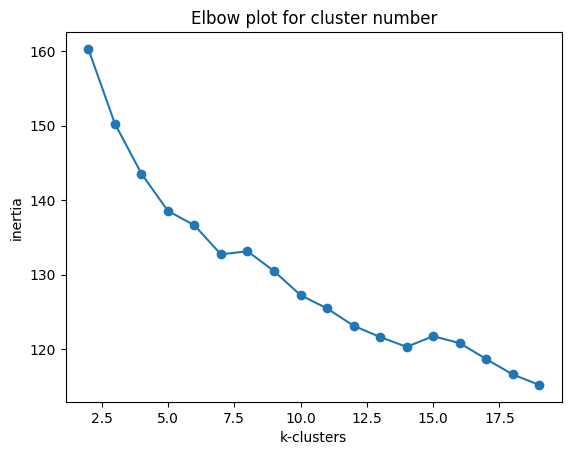

In [60]:
inertias = []
ks = list(range(2, 20))

for k in ks:
    km = KMeans(n_clusters = k, random_state = seed).fit(X)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('k-clusters')
plt.ylabel('inertia')
plt.title('Elbow plot for cluster number')
plt.show()

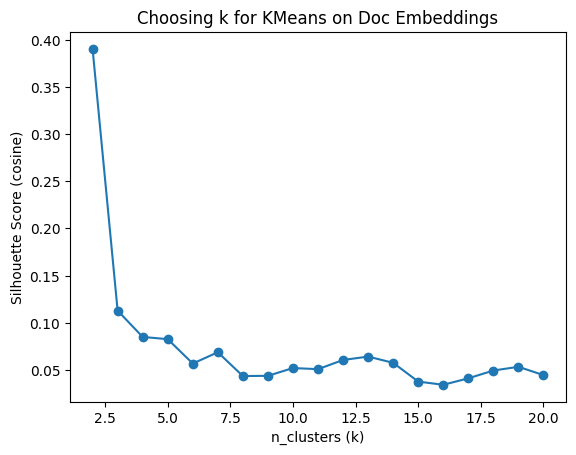

In [61]:
plt.plot(list(K_range), scores_no, marker="o")
plt.xlabel("n_clusters (k)")
plt.ylabel("Silhouette Score (cosine)")
plt.title("Choosing k for KMeans on Doc Embeddings")
plt.show()

In [16]:
best_k_no

2

In [19]:
# difference in Silhouette between best K and k=5: 
best_k_silh = 0.11 
k_5_silh = 0.06 

(k_5_silh / best_k_silh) * 100 

54.54545454545454

## Run 5x BERTopics with different seeds 

In [163]:
import random 

# Generate a random integer between 1 and 1,000 (inclusive)
seed_1 = random.randint(1, 1000)
seed_2 = random.randint(1, 1000)
seed_3 = random.randint(1, 1000)
seed_4 = random.randint(1, 1000)
seed_5 = random.randint(1, 1000)

#seeds = [seed_1, seed_2, seed_3, seed_4, seed_5]

seeds = [15, 158, 24, 5, 336]

print(f"Seeds: {seeds}")

Seeds: [15, 158, 24, 5, 336]


In [165]:
from sklearn.cluster import KMeans
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.metrics import adjusted_rand_score 
from scipy.special import softmax

representation_model = KeyBERTInspired()

# set seeds to try 
#seeds = [42, 7, 2025, 101, 321]
results = [] 

def make_topic_model(seed, n_topics = 5):
    # 1. create k-means with fixed seed 
    kmeans = KMeans(n_clusters = n_topics, random_state = seed)

    # 2. set UMAP with the same seed 
    umap_model = UMAP(random_state = seed, n_components = 2)

    return BERTopic(
        hdbscan_model = kmeans, 
        embedding_model = embedding_model,
        umap_model = umap_model, 
        representation_model = representation_model,
        calculate_probabilities = False       # we will calculate our own pseudo-probs from distance to centroids 
    )

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 5)
    topics, _ = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

In [ ]:

# TRY FOR k=7 

results_7k = [] 

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 7)
    topics, probs = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results_7k.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

#-----------------------------------------
# TRY FOR k=6 

results_6k = [] 

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 6)
    topics, probs = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results_6k.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

#-----------------------------------------

# TRY FOR k=4 

results_4k = [] 

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 4)
    topics, probs = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results_4k.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

#-----------------------------------------

results_3k = [] 

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 3)
    topics, probs = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results_3k.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

In [157]:
# FIXME: changing the 2k results actually to 4-clusters 

# results for k=2 
results_2k = [] 

for seed in seeds:
    topic_model = make_topic_model(seed, n_topics = 2)
    topics, probs = topic_model.fit_transform(docs, embeddings = document_embeddings_stack_500)

    # extract the 2D topic embedding coordinations 
    umap_coords_2d = topic_model.umap_model.embedding_ 

    # calculate pseudo-probs as distance of each points to its k-means cluster centroid 
    kmeans = topic_model.hdbscan_model
    dists = kmeans.transform(umap_coords_2d)

    # turn distances into similarities and then to softmax 
    similarities = 1.0 / (1.0 + dists)
    probs = softmax(similarities, axis = 1)

    results_2k.append({
        'seed' : seed,
        'model' : topic_model, 
        'topics' : topics,
        'probs' : probs,
        'coordinates' : umap_coords_2d
    })

In [139]:
# add topic (cluster) assignments to dataframe (df) 
df['topics_model_1'] = results[0]['topics']
df['topics_model_2'] = results[1]['topics']
df['topics_model_3'] = results[2]['topics']
df['topics_model_4'] = results[3]['topics']
df['topics_model_5'] = results[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df['probs_model_1'] = results[0]['probs'].tolist()
df['probs_model_2'] = results[1]['probs'].tolist()
df['probs_model_3'] = results[2]['probs'].tolist()
df['probs_model_4'] = results[3]['probs'].tolist()
df['probs_model_5'] = results[4]['probs'].tolist()

In [126]:
# dataframe to hold the other k topic results (ie k=3, k=4, k=6, and k=7 to compare to k=5)

df_others = df.copy()

# add topic (cluster) assignments to dataframe (df) 
df_others['topic_model_1_3k'] = results_3k[0]['topics']
df_others['topic_model_2_3k'] = results_3k[1]['topics']
df_others['topic_model_3_3k'] = results_3k[2]['topics']
df_others['topic_model_4_3k'] = results_3k[3]['topics']
df_others['topic_model_5_3k'] = results_3k[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df_others['probs_model_1_3k'] = results_3k[0]['probs'].tolist()
df_others['probs_model_2_3k'] = results_3k[1]['probs'].tolist()
df_others['probs_model_3_3k'] = results_3k[2]['probs'].tolist()
df_others['probs_model_4_3k'] = results_3k[3]['probs'].tolist()
df_others['probs_model_5_3k'] = results_3k[4]['probs'].tolist()

#------------------------------

# add topic (cluster) assignments to dataframe (df) 
df_others['topic_model_1_4k'] = results_4k[0]['topics']
df_others['topic_model_2_4k'] = results_4k[1]['topics']
df_others['topic_model_3_4k'] = results_4k[2]['topics']
df_others['topic_model_4_4k'] = results_4k[3]['topics']
df_others['topic_model_5_4k'] = results_4k[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df_others['probs_model_1_4k'] = results_4k[0]['probs'].tolist()
df_others['probs_model_2_4k'] = results_4k[1]['probs'].tolist()
df_others['probs_model_3_4k'] = results_4k[2]['probs'].tolist()
df_others['probs_model_4_4k'] = results_4k[3]['probs'].tolist()
df_others['probs_model_5_4k'] = results_4k[4]['probs'].tolist()

#------------------------------

# add topic (cluster) assignments to dataframe (df) 
df_others['topic_model_1_6k'] = results_6k[0]['topics']
df_others['topic_model_2_6k'] = results_6k[1]['topics']
df_others['topic_model_3_6k'] = results_6k[2]['topics']
df_others['topic_model_4_6k'] = results_6k[3]['topics']
df_others['topic_model_5_6k'] = results_6k[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df_others['probs_model_1_6k'] = results_6k[0]['probs'].tolist()
df_others['probs_model_2_6k'] = results_6k[1]['probs'].tolist()
df_others['probs_model_3_6k'] = results_6k[2]['probs'].tolist()
df_others['probs_model_4_6k'] = results_6k[3]['probs'].tolist()
df_others['probs_model_5_6k'] = results_6k[4]['probs'].tolist()


#------------------------------

# add topic (cluster) assignments to dataframe (df) 
df_others['topic_model_1_7k'] = results_7k[0]['topics']
df_others['topic_model_2_7k'] = results_7k[1]['topics']
df_others['topic_model_3_7k'] = results_7k[2]['topics']
df_others['topic_model_4_7k'] = results_7k[3]['topics']
df_others['topic_model_5_7k'] = results_7k[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df_others['probs_model_1_7k'] = results_7k[0]['probs'].tolist()
df_others['probs_model_2_7k'] = results_7k[1]['probs'].tolist()
df_others['probs_model_3_7k'] = results_7k[2]['probs'].tolist()
df_others['probs_model_4_7k'] = results_7k[3]['probs'].tolist()
df_others['probs_model_5_7k'] = results_7k[4]['probs'].tolist()

In [127]:
# add topic (cluster) assignments to dataframe (df) 
df['topic_model_1_2k'] = results_2k[0]['topics']
df['topic_model_2_2k'] = results_2k[1]['topics']
df['topic_model_3_2k'] = results_2k[2]['topics']
df['topic_model_4_2k'] = results_2k[3]['topics']
df['topic_model_5_2k'] = results_2k[4]['topics']

# add probabilities (distances to centroids) to dataframe (df)
df['probs_model_1_2k'] = results_2k[0]['probs'].tolist()
df['probs_model_2_2k'] = results_2k[1]['probs'].tolist()
df['probs_model_3_2k'] = results_2k[2]['probs'].tolist()
df['probs_model_4_2k'] = results_2k[3]['probs'].tolist()
df['probs_model_5_2k'] = results_2k[4]['probs'].tolist()

In [128]:
df.loc[0:20, ][['Line Number', 'Year', 'topic_model_1_2k', 'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k', 'topic_model_5_2k']]

,Line Number,Year,topic_model_1_2k,topic_model_2_2k,topic_model_3_2k,topic_model_4_2k,topic_model_5_2k
0,1,2025,0,0,0,0,0
1,2,2024,0,0,0,0,0
2,3,2025,0,0,0,0,0
3,4,2023,1,1,1,1,1
4,4,2023,1,1,1,1,1
5,5,2023,1,1,1,1,1
6,5,2023,1,1,1,1,1
7,5,2023,1,1,1,1,1
8,5,2023,1,1,1,1,1
9,6,2022,1,1,1,1,1


In [129]:
df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count', 'cleaner_text', 'embedding_500',
       'topics_model_1', 'topics_model_2', 'topics_model_3', 'topics_model_4',
       'topics_model_5', 'probs_model_1', 'probs_model_2', 'probs_model_3',
       'probs_model_4', 'probs_model_5', 'topic_model_1_2k',
       'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k',
       'topic_model_5_2k', 'probs_model_1_2k', 'probs_model_2_2k',
       'probs_model_3_2k', 'probs_model_4_2k', 'probs_model_5_2k'],
      dtype='object')

In [107]:
# Write-out data with topics to .csv: 
#df.to_csv('Sections_with_5_topic_model_results_v4.csv', index = False)

### Check ARI between topic results 

Adjusted Rand Index score of 1.0 would mean 2 sets of topic results are identifical. A score of 0.0 would mean they are random (i.e. unrelated to each other). 



In [166]:
print("Comparing each pair of 5-cluster (i.e. 5-topic) results:\n")

totall = 0

for i in range(len(results)):
    for j in range(i + 1, len(results)):
        t1 = results[i]['topics']
        t2 = results[j]['topics']
        ari = adjusted_rand_score(t1, t2)
        print(f"ARI between seed {results[i]['seed']} and {results[j]['seed']}: {ari:.3f}")
        totall += ari 

(totall / 10)

Comparing each pair of 5-cluster (i.e. 5-topic) results:

ARI between seed 15 and 158: 0.750
ARI between seed 15 and 24: 0.407
ARI between seed 15 and 5: 0.759
ARI between seed 15 and 336: 0.772
ARI between seed 158 and 24: 0.403
ARI between seed 158 and 5: 0.800
ARI between seed 158 and 336: 0.724
ARI between seed 24 and 5: 0.403
ARI between seed 24 and 336: 0.434
ARI between seed 5 and 336: 0.824


0.6276819879935609

In [159]:
print("Comparing each pair of 3-cluster (i.e. 3-topic) results:\n")

totall = 0

for i in range(len(results_3k)):
    for j in range(i + 1, len(results_3k)):
        t1 = results_3k[i]['topics']
        t2 = results_3k[j]['topics']
        ari = adjusted_rand_score(t1, t2)
        print(f"ARI between seed {results_3k[i]['seed']} and {results_3k[j]['seed']}: {ari:.3f}")
        totall += ari 

(totall / 10)

Comparing each pair of 3-cluster (i.e. 3-topic) results:

ARI between seed 35 and 77: 0.557
ARI between seed 35 and 89: 0.553
ARI between seed 35 and 21: 0.490
ARI between seed 35 and 24: 0.588
ARI between seed 77 and 89: 0.888
ARI between seed 77 and 21: 0.836
ARI between seed 77 and 24: 0.843
ARI between seed 89 and 21: 0.807
ARI between seed 89 and 24: 0.824
ARI between seed 21 and 24: 0.775


0.7162503630604256

In [160]:
print("Comparing each pair of 4-cluster (i.e. 4-topic) results:\n")

totall = 0

for i in range(len(results_4k)):
    for j in range(i + 1, len(results_4k)):
        t1 = results_4k[i]['topics']
        t2 = results_4k[j]['topics']
        ari = adjusted_rand_score(t1, t2)
        print(f"ARI between seed {results_4k[i]['seed']} and {results_4k[j]['seed']}: {ari:.3f}")
        totall += ari

(totall / 10)

Comparing each pair of 4-cluster (i.e. 4-topic) results:

ARI between seed 35 and 77: 0.487
ARI between seed 35 and 89: 0.580
ARI between seed 35 and 21: 0.545
ARI between seed 35 and 24: 0.645
ARI between seed 77 and 89: 0.752
ARI between seed 77 and 21: 0.714
ARI between seed 77 and 24: 0.659
ARI between seed 89 and 21: 0.778
ARI between seed 89 and 24: 0.737
ARI between seed 21 and 24: 0.628


0.6525419214108419

In [161]:
print("Comparing each pair of 6-cluster (i.e. 6-topic) results:\n")

totall = 0

for i in range(len(results_6k)):
    for j in range(i + 1, len(results_6k)):
        t1 = results_6k[i]['topics']
        t2 = results_6k[j]['topics']
        ari = adjusted_rand_score(t1, t2)
        print(f"ARI between seed {results_6k[i]['seed']} and {results_6k[j]['seed']}: {ari:.3f}")
        totall += ari 

(totall / 10)

Comparing each pair of 6-cluster (i.e. 6-topic) results:

ARI between seed 35 and 77: 0.402
ARI between seed 35 and 89: 0.443
ARI between seed 35 and 21: 0.383
ARI between seed 35 and 24: 0.442
ARI between seed 77 and 89: 0.757
ARI between seed 77 and 21: 0.734
ARI between seed 77 and 24: 0.598
ARI between seed 89 and 21: 0.639
ARI between seed 89 and 24: 0.644
ARI between seed 21 and 24: 0.576


0.5619009319277758

In [162]:
print("Comparing each pair of 7-cluster (i.e. 7-topic) results:\n")

totall = 0 

for i in range(len(results_7k)):
    for j in range(i + 1, len(results_7k)):
        t1 = results_7k[i]['topics']
        t2 = results_7k[j]['topics']
        ari = adjusted_rand_score(t1, t2)
        print(f"ARI between seed {results_7k[i]['seed']} and {results_7k[j]['seed']}: {ari:.3f}")
        totall += ari 

(totall / 10)

Comparing each pair of 7-cluster (i.e. 7-topic) results:

ARI between seed 35 and 77: 0.385
ARI between seed 35 and 89: 0.379
ARI between seed 35 and 21: 0.375
ARI between seed 35 and 24: 0.388
ARI between seed 77 and 89: 0.512
ARI between seed 77 and 21: 0.522
ARI between seed 77 and 24: 0.421
ARI between seed 89 and 21: 0.800
ARI between seed 89 and 24: 0.472
ARI between seed 21 and 24: 0.479


0.47338143054371395

**COMPARE 5x 2-TOPIC RESULTS:** 

In [135]:

print("Comparing each pair of 2-cluster (i.e. 2-topic) results:\n")

for i in range(len(results_2k)):
    for j in range(i + 1, len(results_2k)):
        t1 = results_2k[i]['topics']
        t2 = results_2k[j]['topics']
        ari = adjusted_rand_score(t1, t2)
       
        print(f"ARI between seed {results[i]['seed']} and {results[j]['seed']}: {ari:.3f}")

Comparing each pair of 2-cluster (i.e. 2-topic) results:

ARI between seed 15 and 158: 0.891
ARI between seed 15 and 24: 0.936
ARI between seed 15 and 5: 0.882
ARI between seed 15 and 336: 0.927
ARI between seed 158 and 24: 0.900
ARI between seed 158 and 5: 0.848
ARI between seed 158 and 336: 0.856
ARI between seed 24 and 5: 0.856
ARI between seed 24 and 336: 0.882
ARI between seed 5 and 336: 0.918


### Compare the UMAP axes (D1 and D2)

A low disparity score (Procrustes disparity) means that the overall shape of the topic clusters in 2-dimensions is very similar to one another. 

In [167]:
from scipy.spatial import procrustes 

print("Comparing each pair of 5-cluster (i.e. 5-topic) distance map dimensions (D1 and D2):\n")

coords0 = results[0]['coordinates']

for r in results[1:]:
    mtx1, mtx2, disparity = procrustes(coords0, r['coordinates'])
    print(f"Procrustes disparity of seed {results[0]['seed']} to seed {r['seed']}: {disparity:.4f}")

coords1 = results[1]['coordinates']

for r in results[2:]:
    mtx1, mtx2, disparity = procrustes(coords1, r['coordinates'])
    print(f"Procrustes disparity of seed {results[1]['seed']} to seed {r['seed']}: {disparity:.4f}")

coords2 = results[2]['coordinates']

for r in results[3:]:
    mtx1, mtx2, disparity = procrustes(coords2, r['coordinates'])
    print(f"Procrustes disparity of seed {results[2]['seed']} to seed {r['seed']}: {disparity:.4f}")

coords3 = results[3]['coordinates']

for r in results[4:]:
    mtx1, mtx2, disparity = procrustes(coords3, r['coordinates'])
    print(f"Procrustes disparity of seed {results[3]['seed']} to seed {r['seed']}: {disparity:.4f}")

Comparing each pair of 5-cluster (i.e. 5-topic) distance map dimensions (D1 and D2):

Procrustes disparity of seed 15 to seed 158: 0.0436
Procrustes disparity of seed 15 to seed 24: 0.0254
Procrustes disparity of seed 15 to seed 5: 0.0370
Procrustes disparity of seed 15 to seed 336: 0.0300
Procrustes disparity of seed 158 to seed 24: 0.0446
Procrustes disparity of seed 158 to seed 5: 0.0335
Procrustes disparity of seed 158 to seed 336: 0.0453
Procrustes disparity of seed 24 to seed 5: 0.0439
Procrustes disparity of seed 24 to seed 336: 0.0368
Procrustes disparity of seed 5 to seed 336: 0.0240


In [37]:
print("Comparing each pair of 2-cluster (i.e. 2-topic) distance map dimensions (D1 and D2):\n")

coords0_2k = results_2k[0]['coordinates']

for r_2k in results_2k[1:]:
    mtx1_2k, mtx2_2k, disparity_2k = procrustes(coords0_2k, r_2k['coordinates'])
    print(f"Procrustes disparity of seed {results_2k[0]['seed']} to seed {r_2k['seed']}: {disparity_2k:.4f}")

Comparing each pair of 2-cluster (i.e. 2-topic) distance map dimensions (D1 and D2):

Procrustes disparity of seed 42 to seed 7: 0.0277
Procrustes disparity of seed 42 to seed 2025: 0.0284
Procrustes disparity of seed 42 to seed 101: 0.0292
Procrustes disparity of seed 42 to seed 321: 0.0214


### Combine D1 and D2 axes into one set of axes 

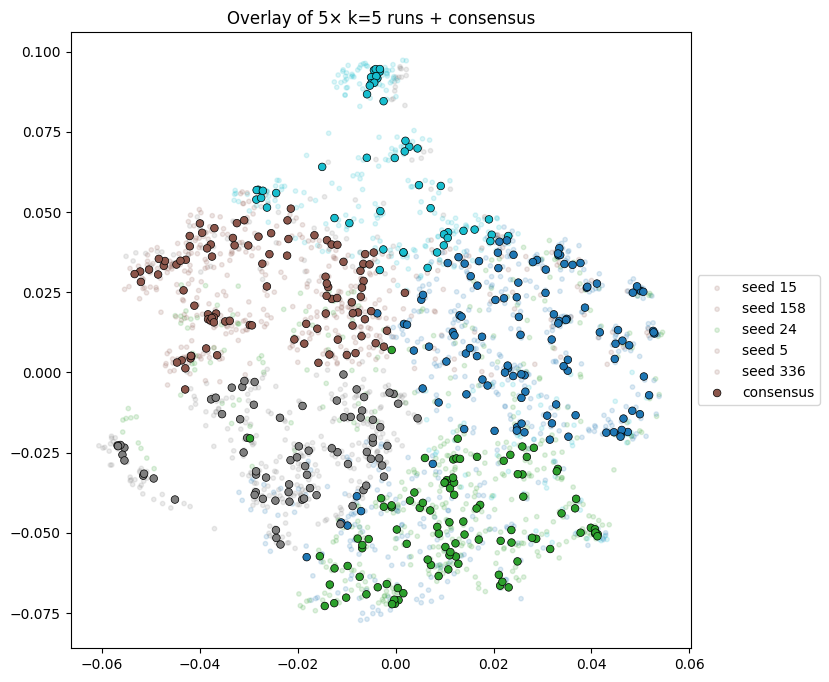

In [168]:
from scipy.stats import mode

labels5 = np.stack([res['topics']      for res in results], axis=1)   # shape (n_docs, 5)
coords5 = [res['coordinates'] for res in results]                    # list of 5 × (n_docs,2)

# 1. Align all UMAP runs to the first seed w Procrustes
# -------------------------------------------------------
ref5 = coords5[0]
aligned5 = []
for c in coords5:
    m1, m2, _ = procrustes(ref5, c)
    aligned5.append(m2)
aligned5 = np.stack(aligned5, axis=2)        # shape (n_docs,2,5)

# 2. Compute consensus labels (majority vote) and consensus coords (mean)
# ----------------------------------------------------------------------
consensus_labels5 = mode(labels5, axis=1).mode.ravel()            # majority label per doc
consensus_coords5 = aligned5.mean(axis=2)                         # average over the 5 runs

# 3. Plot all 5 runs overlayed, plus the consensus
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(8,8))
cmap5 = plt.cm.tab10

# plot each seed's run in light transparency
for i in range(len(results)):
    ax.scatter(aligned5[:,0,i],
               aligned5[:,1,i],
               c=labels5[:,i],
               cmap=cmap5,
               alpha=0.15,
               s=10,
               label=f"seed {results[i]['seed']}")

# plot consensus in bold
scatter = ax.scatter(consensus_coords5[:,0],
                     consensus_coords5[:,1],
                     c=consensus_labels5,
                     cmap=cmap5,
                     alpha=1.0,
                     s=30,
                     edgecolor='k',
                     linewidth=0.5,
                     label="consensus")

ax.set_title("Overlay of 5× k=5 runs + consensus")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

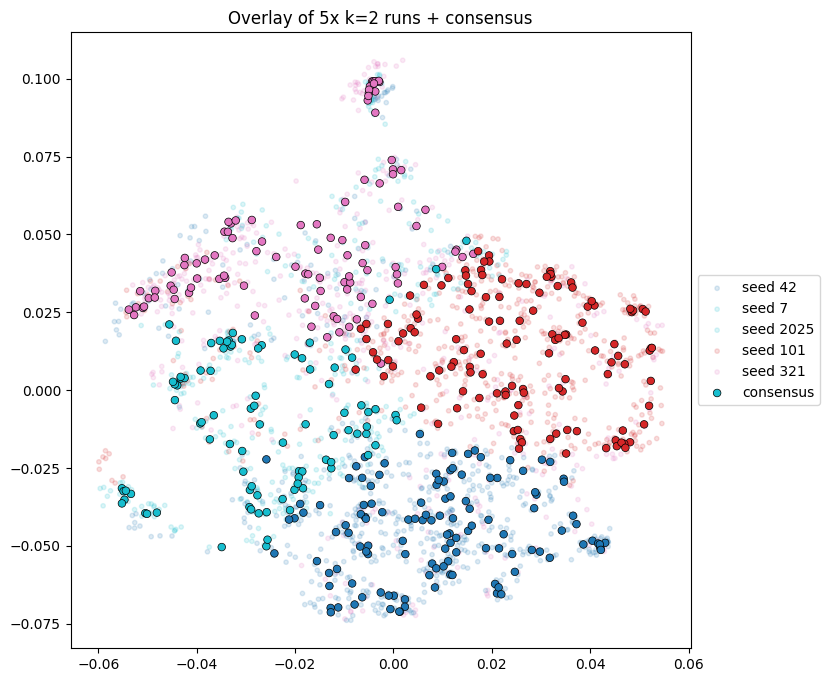

In [39]:
#labels5 = np.stack([res['topics']      for res in results], axis=1)   # shape (n_docs, 5)
#coords5 = [res['coordinates'] for res in results]                    # list of 5 × (n_docs,2)

labels2 = np.stack([res['topics']      for res in results_2k], axis=1)
coords2 = [res['coordinates'] for res in results_2k]

# 1. Align all UMAP runs to the first seed w Procrustes
# -------------------------------------------------------

ref2 = coords2[0]
aligned2 = []
for c in coords2:
    m1, m2, _ = procrustes(ref2, c)
    aligned2.append(m2)
aligned2 = np.stack(aligned2, axis=2)

# 2. Compute consensus labels (majority vote) and consensus coords (mean)
# ----------------------------------------------------------------------
#consensus_labels5 = mode(labels5, axis=1).mode.ravel()            # majority label per doc
#consensus_coords5 = aligned5.mean(axis=2)                         # average over the 5 runs

consensus_labels2 = mode(labels2, axis=1).mode.ravel()
consensus_coords2 = aligned2.mean(axis=2)

# 3. Plot all 5 runs overlayed, plus the consensus
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(8,8))
cmap2 = plt.cm.tab10

# plot each seed's run in light transparency
for i in range(len(results)):
    ax.scatter(aligned2[:,0,i],
               aligned2[:,1,i],
               c=labels2[:,i],
               cmap=cmap2,
               alpha=0.15,
               s=10,
               label=f"seed {results_2k[i]['seed']}")

# plot consensus in bold
scatter = ax.scatter(consensus_coords2[:,0],
                     consensus_coords2[:,1],
                     c=consensus_labels2,
                     cmap=cmap2,
                     alpha=1.0,
                     s=30,
                     edgecolor='k',
                     linewidth=0.5,
                     label="consensus")

ax.set_title("Overlay of 5x k=2 runs + consensus")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

### Calculate meta-data and observational centroid distances to define axes 

#### 1. Sentiment Analysis

In [169]:
from transformers import pipeline
from sklearn.linear_model import Ridge


def get_sentiment(row):
    res = sent(row["section_text"][:512])[0]
    return pd.Series({
        "sentiment_label": res["label"],
        "sentiment_score": res["score"]
    })

# create a Transformer based sentiment analysis pipeline 
sent = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english", 
    device=0  # or -1 for CPU
)

# get sentiment label and score for text 
df[['sentiment_label', 'sentiment_score']] = df.apply(get_sentiment, axis = 1)

Device set to use mps:0


#### 2. Lexical Diversity and Word Count 

In [170]:
df["lexical_diversity"] = (
    df["section_text"]
      .str.split()
      .apply(lambda toks: len(set(toks)) / max(len(toks),1))
)

df["section_word_count"] = df["section_text"].str.split().apply(len)

article_wc = (
    df.groupby("Line Number")["section_word_count"]
      .sum()
      .rename("article_word_count")
)
df = df.join(article_wc, on="Line Number")

#### 3. Get UMAP 2D embeddings from BERT topic models 

In [171]:
# get D1 and D2 (and topics) from consensus of all 5x models for the 2-topic model:
df[["D1_consensus_2k", "D2_consensus_2k"]] = pd.DataFrame(
    consensus_coords2,
    columns=["D1_consensus_2k", "D2_consensus_2k"],
    index=df.index
)

df["topic_consensus_2k"] = consensus_labels2

NameError: name 'consensus_coords2' is not defined

In [172]:
# get D1 and D2 (and topics) from consensus of all 5x models 
df[["D1_consensus", "D2_consensus"]] = pd.DataFrame(
    consensus_coords5,
    columns=["D1_consensus", "D2_consensus"],
    index=df.index
)

df["topic_consensus"] = consensus_labels5

### Also need to take consensus of probabilities (i.e. distances to centroids)

In [174]:
from scipy.spatial.distance import euclidean

def compute_probs(coords, labels):
    centroids = {
        lbl: coords[labels == lbl].mean(axis = 0)
        for lbl in np.unique(labels)
    }

    return np.array([
        1.0 / (1.0 + euclidean(c, centroids[lbl]))
        for c, lbl in zip(coords, labels)
    ])

df['prob_consensus'] = compute_probs(consensus_coords5, consensus_labels5)
#df['prob_consensus_2k'] = compute_probs(consensus_coords2, consensus_labels2)

#df

### Correlate D-axes with meta-data 

Find relationships between meta-data and the D1 and D2 consensus axes. 

In [175]:
corr = df[["D1_consensus", "D2_consensus", "Year", "sentiment_score", "lexical_diversity", "article_word_count"]].corr()
print("=== correlations of D1/D2 with your key vars ===")
print(corr.loc[["D1_consensus", "D2_consensus"], 
               ["Year", "sentiment_score", "lexical_diversity", "article_word_count"]])

=== correlations of D1/D2 with your key vars ===
                  Year  sentiment_score  lexical_diversity  article_word_count
D1_consensus -0.066845         0.011752          -0.257212           -0.006802
D2_consensus -0.330418         0.040113           0.404647           -0.281833


In [48]:
for var in ["Year", "sentiment_score", "lexical_diversity", "article_word_count"]:
    """plt.figure(figsize=(6,4))
    sns.regplot(data=df, x="D1_consensus", y=var, scatter_kws={"s":10}, line_kws={"color":"C1"})
    plt.title(f"D1 --> {var}")
    plt.show()"""
    pass 

In [49]:
for var in ["Year", "sentiment_score", "lexical_diversity", "article_word_count"]:
    """plt.figure(figsize=(6,4))
    sns.regplot(data=df, x="D2_consensus", y=var, scatter_kws={"s":10}, line_kws={"color":"C1"})
    plt.title(f"D2 --> {var}")
    plt.show()"""
    pass 

## Write-out top5 and bottom5 for D1 and D2 

### Look at extremes on D1 axis 

In [176]:
n = int(len(df) * 0.05)  # top/bottom 5%
top5 = df.nlargest(n, "D1_consensus")
bot5 = df.nsmallest(n, "D1_consensus")

print("\n== Top-5% of sections by D1 ==")
#print(top5["topics_model_1"].value_counts().head())
print(top5['topic_consensus'].value_counts().head())
print("\n== Bottom-5% of sections by D1 ==")
#print(bot5["topics_model_1"].value_counts().head())
print(bot5["topic_consensus"].value_counts().head())

print("\n-- Sample texts at high-D1 --")
for t in top5["section_text"].sample(3):
    #print("•", t[:200].replace("\n"," "), "…\n")
    pass

print("\n-- Sample texts at low-D1 --")
for t in bot5["section_text"].sample(3):
    #print("•", t[:200].replace("\n"," "), "…\n")
    pass




== Top-5% of sections by D1 ==
topic_consensus
0    21
Name: count, dtype: int64

== Bottom-5% of sections by D1 ==
topic_consensus
2    11
3    10
Name: count, dtype: int64

-- Sample texts at high-D1 --

-- Sample texts at low-D1 --


#### Look at extremes on D2 

In [177]:
n = int(len(df) * 0.05)  # top/bottom 5%
top5 = df.nlargest(n, "D2_consensus")
bot5 = df.nsmallest(n, "D2_consensus")

print("\n== Top-5% of sections by D2 ==")
#print(top5["topics_model_1"].value_counts().head())
print(top5["topic_consensus"].value_counts().head())
print("\n== Bottom-5% of sections by D2 ==")
#print(bot5["topics_model_1"].value_counts().head())
print(bot5["topic_consensus"].value_counts().head())

print("\n-- Sample texts at high-D2 --")
for t in top5["section_text"].sample(3):
    #print("•", t[:200].replace("\n"," "), "…\n")
    pass

print("\n-- Sample texts at low-D2 --")
for t in bot5["section_text"].sample(3):
    #print("•", t[:200].replace("\n"," "), "…\n")
    pass



== Top-5% of sections by D2 ==
topic_consensus
4    21
Name: count, dtype: int64

== Bottom-5% of sections by D2 ==
topic_consensus
1    21
Name: count, dtype: int64

-- Sample texts at high-D2 --

-- Sample texts at low-D2 --


### Create columns for top5 and bottom5 D1 and D2 

In [182]:
for axis in [0, 1]:
    name = ['D1_consensus', 'D2_consensus'][axis]
    n_top = max(1, int(len(df) * 0.05))
    top_idx = np.argsort(consensus_coords5[:, axis])[-n_top:]
    bottom_idx = np.argsort(consensus_coords5[:, axis])[:n_top]
    df['top5_' + name] = 0
    df['bottom5_' + name] = 0
    df.loc[top_idx, 'top5_' + name] = 1
    df.loc[bottom_idx, 'bottom5_' + name] = 1

In [183]:
df.to_csv("Sections_with_5_topic_consensus_v2.csv", index = False)

### Plot topic centroids in D1 and D2 space 

In [3]:
import pandas as pd 
import numpy as np 

df = pd.read_csv("Sections_with_5_topic_consensus_v2.csv")

df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count', 'cleaner_text', 'embedding_500',
       'topics_model_1', 'topics_model_2', 'topics_model_3', 'topics_model_4',
       'topics_model_5', 'probs_model_1', 'probs_model_2', 'probs_model_3',
       'probs_model_4', 'probs_model_5', 'topic_model_1_2k',
       'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k',
       'topic_model_5_2k', 'probs_model_1_2k', 'probs_model_2_2k',
       'probs_model_3_2k', 'probs_model_4_2k', 'probs_model_5_2k',
       'sentiment_label', 'sentiment_score', 'lexical_diversity',
       'article_word_count', 'D1_consensus', 'D2_consensus', 'topic_consensus',
       'prob_consensus', 'top5_D1_consensus', 'bottom5_D1_consensus',
       'top5_D2_consensus', 'bottom5_D2_consensus'],
      dtype='object')

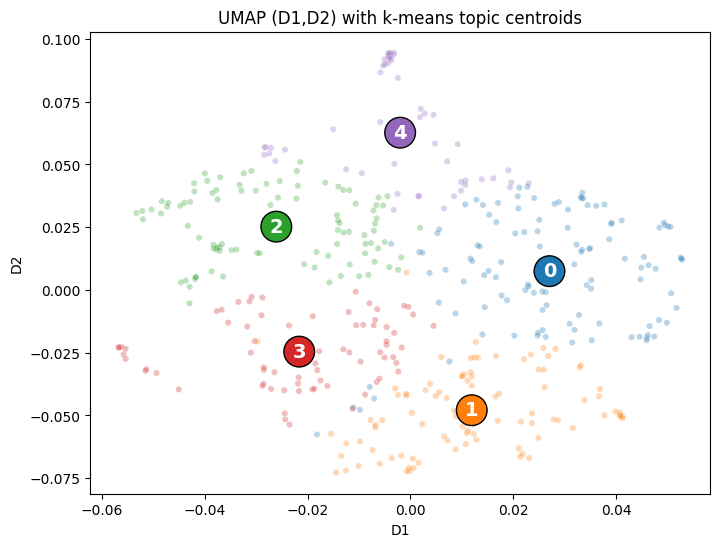

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns

centroids = (
    df
    .groupby("topic_consensus")[["D1_consensus","D2_consensus"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="D1_consensus", y="D2_consensus", hue="topic_consensus",
                palette="tab10", s=20, alpha=0.3, legend=False)

# annotate each centroid
for _, row in centroids.iterrows():
    t = int(row["topic_consensus"])
    x,y = row["D1_consensus"], row["D2_consensus"]
    plt.text(x, y, f"{t}", fontsize=14, fontweight="bold",
             ha="center", va="center", color="white",
             bbox=dict(boxstyle="circle,pad=0.3", fc="C"+str(t), ec="black", lw=1))
plt.title("UMAP (D1,D2) with k-means topic centroids")
plt.xlabel("D1"); plt.ylabel("D2")
plt.show() 

In [134]:
df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count', 'cleaner_text', 'embedding_500',
       'topics_model_1', 'topics_model_2', 'topics_model_3', 'topics_model_4',
       'topics_model_5', 'probs_model_1', 'probs_model_2', 'probs_model_3',
       'probs_model_4', 'probs_model_5', 'topic_model_1_2k',
       'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k',
       'topic_model_5_2k', 'probs_model_1_2k', 'probs_model_2_2k',
       'probs_model_3_2k', 'probs_model_4_2k', 'probs_model_5_2k',
       'sentiment_label', 'sentiment_score', 'lexical_diversity',
       'article_word_count', 'D1_consensus', 'D2_consensus', 'topic_consensus',
       'prob_consensus', 'top5_D1_consensus', 'bottom5_D1_consensus',
       'top5_D2_consensus', 'bottom5_D2_consensus'],
      dtype='object')

## Getting top n-grams (words) from each axis and topic 

In [137]:
df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count', 'cleaner_text', 'embedding_500',
       'topics_model_1', 'topics_model_2', 'topics_model_3', 'topics_model_4',
       'topics_model_5', 'probs_model_1', 'probs_model_2', 'probs_model_3',
       'probs_model_4', 'probs_model_5', 'topic_model_1_2k',
       'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k',
       'topic_model_5_2k', 'probs_model_1_2k', 'probs_model_2_2k',
       'probs_model_3_2k', 'probs_model_4_2k', 'probs_model_5_2k',
       'sentiment_label', 'sentiment_score', 'lexical_diversity',
       'article_word_count', 'D1_consensus', 'D2_consensus', 'topic_consensus',
       'prob_consensus', 'top5_D1_consensus', 'bottom5_D1_consensus',
       'top5_D2_consensus', 'bottom5_D2_consensus'],
      dtype='object')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(docs, n = 50, ngram_range = (1, 2), stop_words = 'english'):

    vec = CountVectorizer(
        ngram_range = ngram_range, 
        stop_words = stop_words, 
        token_pattern = r'\b\w+\b'
    )

    X = vec.fit_transform(docs)
    counts = np.asarray(X.sum(axis = 0)).ravel()
    terms = vec.get_feature_names_out()
    top_i = counts.argsort()[::-1][:n]
    return [(terms[i], int(counts[i])) for i in top_i]

topic_ngrams = {}
for topic in sorted(df['topic_consensus'].unique()):
    docs = df.loc[df['topic_consensus'] == topic, 'section_text']
    topic_ngrams[topic] = {
        'unigrams': get_top_ngrams(docs, n=20, ngram_range=(1,1)),
        'bigrams' : get_top_ngrams(docs, n=20, ngram_range=(2,2))
    }

extremes = {
    'top5_D1'    : df.loc[df['top5_D1_consensus']   == 1, 'section_text'],
    'bottom5_D1' : df.loc[df['bottom5_D1_consensus']== 1, 'section_text'],
    'top5_D2'    : df.loc[df['top5_D2_consensus']   == 1, 'section_text'],
    'bottom5_D2' : df.loc[df['bottom5_D2_consensus']== 1, 'section_text']
}

extreme_ngrams = {
    name: {
      'unigrams': get_top_ngrams(texts, n=20, ngram_range=(1,1)),
      'bigrams' : get_top_ngrams(texts, n=20, ngram_range=(2,2))
    }
    for name, texts in extremes.items()
}

extreme_ngrams

{'top5_D1': {'unigrams': [('image', 179),
   ('know', 156),
   ('like', 126),
   ('s', 112),
   ('thing', 101),
   ('think', 95),
   ('kind', 95),
   ('ai', 93),
   ('sort', 89),
   ('art', 62),
   ('model', 62),
   ('human', 57),
   ('deep', 57),
   ('network', 52),
   ('generate', 52),
   ('neural', 47),
   ('look', 46),
   ('learn', 44),
   ('let', 42),
   ('train', 41)],
  'bigrams': [('et al', 30),
   ('neural network', 28),
   ('deep dream', 22),
   ('ai art', 17),
   ('generate image', 12),
   ('mental image', 12),
   ('look like', 12),
   ('dream algorithm', 11),
   ('thing like', 10),
   ('deep learning', 10),
   ('little bit', 9),
   ('gradient ascent', 9),
   ('input image', 9),
   ('artificial neural', 8),
   ('math function', 8),
   ('like human', 8),
   ('image image', 7),
   ('abstract idea', 7),
   ('al 2013', 7),
   ('generative ai', 6)]},
 'bottom5_D1': {'unigrams': [('ai', 144),
   ('art', 122),
   ('artist', 105),
   ('technology', 65),
   ('human', 63),
   ('work',

In [6]:
def exclusive_terms(ngram_dict):
    sets = { g: {t for t,_ in lst} for g,lst in ngram_dict.items() }
    exclusive = {}
    for g in sets:
        others = set().union(*(sets[h] for h in sets if h!=g))
        exclusive[g] = sets[g] - others
    return exclusive

exclusive_by_topic   = exclusive_terms({t: topic_ngrams[t]['unigrams'] for t in topic_ngrams})
exclusive_by_extreme = exclusive_terms({e: extreme_ngrams[e]['unigrams'] for e in extreme_ngrams})

exclusive_by_topic

{0: {'look'},
 1: {'right', 'tool', 've', 'yeah'},
 2: {'artistic', 'cohen', 'question', 'world'},
 3: {'come', 'talk'},
 4: {'artificial', 'copyright', 'digital', 'generate', 'piece', 'software'}}

In [7]:
exclusive_by_extreme

{'top5_D1': {'deep',
  'generate',
  'learn',
  'let',
  'look',
  'model',
  'network',
  'neural',
  'sort',
  'train'},
 'bottom5_D1': {'artistic',
  'collective',
  'community',
  'music',
  'say',
  'technology',
  'tool'},
 'top5_D2': {'artificial',
  'author',
  'code',
  'coder',
  'copyright',
  'intelligence',
  'law',
  'original',
  'piece',
  'protection',
  'software'},
 'bottom5_D2': {'digital',
  'lot',
  'm',
  'market',
  'mean',
  'need',
  'right',
  'yeah'}}

In [8]:
# Topic × top-20 unigrams
topic_uni_df = pd.DataFrame({
    t: [w for w,_ in topic_ngrams[t]['unigrams'][:20]]
    for t in topic_ngrams
})

# Extremes × top-20 unigrams
ext_uni_df = pd.DataFrame({
    e: [w for w,_ in extreme_ngrams[e]['unigrams'][:20]]
    for e in extreme_ngrams
})

print("SAMPLE OF HOW TO USE THESE RESULTS:\n---")
print("Topic 0 top-5 unigrams:", topic_ngrams[0]['unigrams'][:10])
print("Exclusive to Topic 0:", exclusive_by_topic[0])

print("\n")

print("Top-10 bigrams @ top5_D2:", extreme_ngrams['top5_D2']['bigrams'][:10])
print("Exclusive unigrams @ bottom5_D1:", exclusive_by_extreme['bottom5_D1'])



SAMPLE OF HOW TO USE THESE RESULTS:
---
Topic 0 top-5 unigrams: [('ai', 797), ('art', 742), ('like', 561), ('image', 555), ('work', 421), ('know', 407), ('s', 400), ('human', 370), ('artist', 367), ('think', 324)]
Exclusive to Topic 0: {'look'}


Top-10 bigrams @ top5_D2: [('artificial intelligence', 39), ('copyright law', 34), ('copyright protection', 33), ('piece art', 21), ('supra note', 21), ('copyright office', 19), ('creative robot', 19), ('2025 report', 17), ('ai art', 16), ('copyright coverage', 16)]
Exclusive unigrams @ bottom5_D1: {'say', 'music', 'technology', 'collective', 'community', 'tool', 'artistic'}


### Top 20 words for each of the 5 topics 

In [9]:
print(topic_uni_df)

               0       1           2           3             4
0             ai    like         art        like            ai
1            art    know          ai       think           art
2           like   think      artist        know     copyright
3          image       s        work         art          work
4           work     art       human          ai         human
5           know  people         new           s        artist
6              s      ai  technology      people         image
7          human   thing       image      artist      creative
8         artist   right        like       thing        create
9          think  artist       world        work       digital
10         thing    work      create  technology  intelligence
11        create       m    computer           m           new
12           new    yeah    creative         way    artificial
13          kind     way     machine         new       machine
14           way     lot       cohen        want    cre

### Top 20 words for each of the axis extremes 

In [10]:

print(ext_uni_df)

     top5_D1  bottom5_D1       top5_D2 bottom5_D2
0      image          ai     copyright       like
1       know         art          work       know
2       like      artist            ai          s
3          s  technology           art      think
4      thing       human         human        art
5      think        work        create     artist
6       kind        like      creative     people
7         ai         new         piece       work
8       sort       music      software      right
9        art      create        artist       yeah
10     model        tool           law          m
11     human    creative         image      thing
12      deep      people          code    digital
13   network        know    protection       kind
14  generate         say           new         ai
15    neural    artistic    artificial       mean
16      look           s  intelligence        lot
17     learn   community      original     market
18       let         way        author        way


## Extra steps to determine D1 and D2 axis spectra 

Previously, we just take the top 20 unigrams and bigrams per top and bottom 5% of observations on each axis. We then find which of these top 20 unigrams and bigrams are exclusive to each of the top and bottom 5% sections. This gives us a somewhat quantitative and somewhat qualitative way to describe each axis spectrum. 

Here, we can setup a logistic classification to predict if data is at different locations on the axis based on the TF-IDF features. Then, we can look at non-zero coefficients to see which words most strongly push a section toward the artistic vs technical engineering poles (D1) or the general market vs legal and regulatory poles (D2). 

For the above, we will at first make a binary column for top-20% vs bottom-20% quantiles of one axis. Then, we can do the same but making 4 classes, 1x for each 25% quantile going from low to high on the same axis. We then do the same two steps for the other axis. 



In [61]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# ───────────────────────────────────────────────────────────────────────────────
# 1) LABEL CREATION
# ───────────────────────────────────────────────────────────────────────────────
def make_axis_labels(df, axis_col, top_pct=0.20, bottom_pct=0.20):
    """
    Adds four columns to df:
      - <axis>_top   : 1 if in top top_pct of axis_col, else 0
      - <axis>_bottom: 1 if in bottom bottom_pct of axis_col, else 0
      - <axis>_quartile: 1–4 label
    """
    q_low  = df[axis_col].quantile(bottom_pct)
    q_high = df[axis_col].quantile(1-top_pct)
    df[f"{axis_col}_top"]    = (df[axis_col] >= q_high).astype(int)
    df[f"{axis_col}_bottom"] = (df[axis_col] <= q_low).astype(int)
    df[f"{axis_col}_quartile"] = pd.qcut(
        df[axis_col], q=4, labels=[1,2,3,4]
    ).astype(int)
    return df

# ───────────────────────────────────────────────────────────────────────────────
# 2) VECTORIZATION
# ───────────────────────────────────────────────────────────────────────────────
def get_vectorizer(corpus, max_features=5000, ngram_range=(1,3)):
    """Fit & return a TF-IDF vectorizer plus the transformed matrix X."""
    vect = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X = vect.fit_transform(corpus)
    return vect, X

# ───────────────────────────────────────────────────────────────────────────────
# 3) TRAIN & EXTRACT FEATURES
# ───────────────────────────────────────────────────────────────────────────────
def train_and_extract(
    X, y, feature_names,
    model_type="logistic",
    top_pos_k=20, top_neg_k=20,
    test_size=0.2, random_state=42
):
    """
    Train either a logistic or random forest on X,y.
    Returns the fitted model and dict of top features per class.
    """
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    if model_type=="logistic":
        clf = LogisticRegression(
            penalty="l1", solver="saga", class_weight="balanced",
            C=1.0, max_iter=1000, random_state=random_state
        )
    elif model_type=="rf":
        clf = RandomForestClassifier(
            n_estimators=200, class_weight="balanced",
            random_state=random_state, n_jobs=-1
        )
    else:
        raise ValueError("model_type must be 'logistic' or 'rf'")
    
    clf.fit(Xtr, ytr)
    print(f"\n--- {model_type.upper()} classification report ---")
    print(classification_report(yte, clf.predict(Xte), zero_division=0))
    
    # extract top features
    top_features = {}
    if model_type=="logistic":
        coefs = clf.coef_
        if coefs.ndim == 1:  # binary
            pos_idx = np.argsort(coefs)[-top_pos_k:]
            neg_idx = np.argsort(coefs)[:top_neg_k]
            top_features[1] = feature_names[pos_idx]
            top_features[0] = feature_names[neg_idx]
        else:  # multiclass
            for cls, row in enumerate(coefs):
                idx = np.argsort(row)
                top_features[cls] = feature_names[idx[-top_pos_k:]]
    else:  # random forest
        imps = clf.feature_importances_
        if imps.ndim == 1:  # binary/multiclass mixture
            # for RF we'll just show top k overall, as RF isn't inherently directional
            idx = np.argsort(imps)[-top_pos_k:]
            top_features["rf_top"] = feature_names[idx]
        else:
            # rare
            pass
    
    return clf, top_features

# ───────────────────────────────────────────────────────────────────────────────
# 4) EXCLUSIVITY ANALYSIS
# ───────────────────────────────────────────────────────────────────────────────
def exclusive_terms(per_class_feats):
    """
    Given dict: class -> array of top features,
    return dict: class -> set of features unique to that class.
    """
    all_sets = {cls:set(feats) for cls, feats in per_class_feats.items()}
    excl = {}
    for cls, terms in all_sets.items():
        others = set().union(*(v for k,v in all_sets.items() if k!=cls))
        excl[cls] = terms - others
    return excl

# ───────────────────────────────────────────────────────────────────────────────
# 5) RUN IT FOR EACH TARGET & MODEL
# ───────────────────────────────────────────────────────────────────────────────
def classify_words_on_axis(df, X, colname, short, feature_names, top_pos_words = 500, top_neg_words = 500):
    results = {} 

    y = df[colname].values
    print(f"\n==== TARGET: {colname} ====")
    print("Running logistic classification...")

    log_clf, log_feats = train_and_extract(
        X, y, feature_names, model_type = "logistic", 
        top_pos_k = top_pos_words, top_neg_k = top_neg_words
    )
    log_exclusive = exclusive_terms(log_feats)

    print("Logistic classification completed.")

    print("Running random forest classifier...")
    rf_clf, rf_feats = train_and_extract(
        X, y, feature_names, model_type = "rf",
        top_pos_k = top_pos_words
    )
    rf_exclusive = exclusive_terms(rf_feats)

    print("Random forest classifier complete.")

    results[colname] = {
        "logistic_features":  log_feats,
        "logistic_exclusive": log_exclusive,
        "rf_features":        rf_feats,
        "rf_exclusive":       rf_exclusive,
    }

    return results



# Make labels 
df = make_axis_labels(df, "D1_consensus", top_pct=0.50, bottom_pct=0.50)
df = make_axis_labels(df, "D2_consensus", top_pct=0.50, bottom_pct=0.50)

# vectorize 
vectorizer, X = get_vectorizer(df["section_text"])

# targets
colname_d1_top = "D1_consensus_top"
short_d1_top = "d1_top"
colname_d1_bottom = "D1_consensus_bottom"
short_d1_bottom = "d1_bottom"

feature_names = vectorizer.get_feature_names_out()

results_d1_top = classify_words_on_axis(df, X, colname_d1_top, short_d1_top, feature_names, top_pos_words = 500, top_neg_words = 500)
results_d1_bottom = classify_words_on_axis(df, X, colname_d1_bottom, short_d1_bottom, feature_names, top_pos_words = 500, top_neg_words = 500)


==== TARGET: D1_consensus_top ====
Running logistic classification...

--- LOGISTIC classification report ---
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        43
           1       0.74      0.67      0.71        43

    accuracy                           0.72        86
   macro avg       0.72      0.72      0.72        86
weighted avg       0.72      0.72      0.72        86

Logistic classification completed.
Running random forest classifier...

--- RF classification report ---
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        43
           1       0.73      0.77      0.75        43

    accuracy                           0.74        86
   macro avg       0.74      0.74      0.74        86
weighted avg       0.74      0.74      0.74        86

Random forest classifier complete.

==== TARGET: D1_consensus_bottom ====
Running logistic classification...

--- LOGISTIC classif

### Look at exclusive words per top / bottom 50% of each axis 


In [65]:
results_d1_top[colname_d1_top].keys()

dict_keys(['logistic_features', 'logistic_exclusive', 'rf_features', 'rf_exclusive'])

In [69]:
results_d1_top[colname_d1_top]['logistic_features']

{0: array(['dress', 'dream hallucinate', 'dream algorithm', 'dream',
        'drawing', 'draw line', 'ear', 'early', 'early computer',
        'early day', 'ecosystem', 'economy', 'economic forum', 'economic',
        'eck', 'echo', 'eat', 'edge', 'easy thing', 'east', 'easily',
        'ease', 'earth', 'earn', 'early work', 'early example', 'easy',
        'digital art design', 'digital art', 'digest',
        'decentralize technology', 'decentralize', 'decentralised',
        'december', 'decade ago', 'decade', 'debate', 'death', 'dealer',
        'deal', 'dead', 'de belamy', 'de', 'day like', 'day', 'decide',
        'decision', 'decision make', 'decisionmake', 'deepfake',
        'deepdreamc', 'deepdream', 'deep neural network', 'deep neural',
        'deep learning', 'deep learn', 'davis', 'deep dream algorithm',
        'deep blue', 'deep', 'deem', 'dedicate', 'decorative', 'decline',
        'declare', 'deep dream', 'deeply', 'david', 'datum train', 'daily',
        'da vinci', 

In [70]:
results_d1_bottom[colname_d1_bottom]['logistic_features']

{0: array(['dream hallucinate', 'dream algorithm', 'dream', 'drawing',
        'draw line', 'draw', 'dramatically', 'dynamic', 'dystopian', 'ear',
        'early', 'economic forum', 'economic', 'eck', 'echo', 'eat',
        'easy thing', 'easy', 'ecosystem', 'east', 'ease', 'earth', 'earn',
        'early work', 'early example', 'early day', 'early computer',
        'easily', 'digital', 'digest', 'dig', 'decentralize',
        'decentralised', 'december', 'decade ago', 'decade', 'debate',
        'death', 'dealer', 'deal', 'dead', 'de belamy', 'de', 'day like',
        'day', 'davis', 'decentralize technology', 'decide', 'decision',
        'decision make', 'deepdreamc', 'deepdream', 'deep neural network',
        'deep neural', 'deep learning', 'deep learn',
        'deep dream algorithm', 'david', 'deep dream', 'deep', 'deem',
        'dedicate', 'decorative', 'decline', 'declare', 'decisionmake',
        'deep blue', 'deepfake', 'daughter', 'datum set', 'da vinci', 'da',
        'c

In [71]:
targets = [
    ("D1_consensus_top",    "d1_top"),
    ("D1_consensus_bottom", "d1_bottom"),
    ("D1_consensus_quartile","d1_quartile"),
    ("D2_consensus_top",    "d2_top"),
    ("D2_consensus_bottom", "d2_bottom"),
    ("D2_consensus_quartile","d2_quartile"),
]

feature_names = vectorizer.get_feature_names_out()
results = {}

for colname, short in targets:
    y = df[colname].values
    print(f"\n===== TARGET: {colname} =====")
    # logistic
    log_clf, log_feats = train_and_extract(
        X, y, feature_names,
        model_type="logistic",
        top_pos_k=15, top_neg_k=15
    )
    log_excl = exclusive_terms(log_feats)
    
    # random forest
    rf_clf, rf_feats = train_and_extract(
        X, y, feature_names,
        model_type="rf",
        top_pos_k=15
    )
    rf_excl = exclusive_terms(rf_feats)
    
    results[colname] = {
        "logistic_features":  log_feats,
        "logistic_exclusive": log_excl,
        "rf_features":        rf_feats,
        "rf_exclusive":       rf_excl,
    }


===== TARGET: D1_consensus_top =====

--- LOGISTIC classification report ---
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        43
           1       0.74      0.67      0.71        43

    accuracy                           0.72        86
   macro avg       0.72      0.72      0.72        86
weighted avg       0.72      0.72      0.72        86


--- RF classification report ---
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        43
           1       0.73      0.77      0.75        43

    accuracy                           0.74        86
   macro avg       0.74      0.74      0.74        86
weighted avg       0.74      0.74      0.74        86


===== TARGET: D1_consensus_bottom =====

--- LOGISTIC classification report ---
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        43
           1       0.67      0.77      0.72 

In [75]:
results['D1_consensus_top']['logistic_exclusive']


{0: {'event',
  'eventually',
  'everybody',
  'everybody know',
  'everybody want',
  'everybodys',
  'everyday life',
  'everyone',
  'evidence',
  'image',
  'like',
  'model',
  'neural',
  'not',
  'zurich'}}

## p-value for paper 

Want to look at the alignment of our topic clusters and Lovato's Research Question. 

**Distribution of artists' concerns:**

- RQ1 (Threat): 61.87% (our cluster 3) 
- RQ2 (Utility): 44.88% (our cluster 1) 
- RQ3 (Transparency): 80.17% (our cluster 4) 
- RQ4 (Ownership): 41.39% (our cluster 2) 



In [13]:
df_rq = df[df['topic_consensus'].isin([1, 2, 3, 4])]
N = len(df_rq) 

# observed counts by cluster 
obs_counts = df_rq['topic_consensus'].value_counts().sort_index() 

obs_props = obs_counts / N 
display(obs_props)

topic_consensus
1    0.302839
2    0.299685
3    0.236593
4    0.160883
Name: count, dtype: float64

In [15]:
p_lovato = {
    3: 0.6187,
    1: 0.4488,
    4: 0.8017,
    2: 0.4139
}

total = sum(p_lovato.values())
p0 = {k: v/total for k,v in p_lovato.items()}
print("Expected proportions under H0:", p0)

Expected proportions under H0: {3: 0.27099119618063167, 1: 0.19657483246463145, 4: 0.3511453725198196, 2: 0.18128859883491746}


In [31]:
from statsmodels.stats.proportion import proportions_ztest


# ─────────────────────────────────────────────────────────────────────────────
# 1) Normalize D1/D2 onto [-1, +1]
#    so that negative=“low” and positive=“high” on each axis
# ─────────────────────────────────────────────────────────────────────────────
# compute global min/max from your df
d1_min, d1_max = df["D1_consensus"].min(), df["D1_consensus"].max()
d2_min, d2_max = df["D2_consensus"].min(), df["D2_consensus"].max()

# linear rescaling into [-1,1]
df["D1_norm"] = 2 * (df["D1_consensus"] - d1_min) / (d1_max - d1_min) - 1
df["D2_norm"] = 2 * (df["D2_consensus"] - d2_min) / (d2_max - d2_min) - 1


# ─────────────────────────────────────────────────────────────────────────────
# 2) Compute quadrant‐based “raw weights” for each research question frame
#    Quadrant definitions (as per Figure 1):
#      • Threat       = bottom‐left  = (D1<0, D2<0)
#      • Utility      = bottom‐right = (D1>0, D2<0)
#      • Transparency = top‐right    = (D1>0, D2>0)
#      • Ownership    = top‐left     = (D1<0, D2>0)
# ─────────────────────────────────────────────────────────────────────────────
# For each section, we take the *positive* part in the appropriate half-axis,
# multiply them, and then normalize so all four weights sum to 1.

# raw quadrant‐weights
df["w_threat_raw"]      = (-df["D1_norm"].clip(upper=0)) * (-df["D2_norm"].clip(upper=0))
df["w_utility_raw"]     = ( df["D1_norm"].clip(lower=0)) * (-df["D2_norm"].clip(upper=0))
df["w_transparency_raw"]= ( df["D1_norm"].clip(lower=0)) * ( df["D2_norm"].clip(lower=0))
df["w_ownership_raw"]   = (-df["D1_norm"].clip(upper=0)) * ( df["D2_norm"].clip(lower=0))

# normalization constant (per row)
df["w_sum"] = (
    df["w_threat_raw"]
  + df["w_utility_raw"]
  + df["w_transparency_raw"]
  + df["w_ownership_raw"]
)

# final fractional alignments
df["p_threat"]      = df["w_threat_raw"]      / df["w_sum"]
df["p_utility"]     = df["w_utility_raw"]     / df["w_sum"]
df["p_transparency"]= df["w_transparency_raw"]/ df["w_sum"]
df["p_ownership"]   = df["w_ownership_raw"]   / df["w_sum"]


# ─────────────────────────────────────────────────────────────────────────────
# 3) Compute corpus‐level means P_obs and compare to Lovato survey P0 via z‐test
# ─────────────────────────────────────────────────────────────────────────────
# observed proportions (the average fractional “vote” for each frame)
P_obs = df[["p_threat","p_utility","p_transparency","p_ownership"]].mean()

total_lovato = (0.6187 + 0.4488 + 0.8017 + 0.4139)

# survey benchmarks from Lovato et al. (2024)
P_lovato = {
    'p_threat':       (0.6187 / total_lovato),  # RQ1
    'p_utility':      (0.4488 / total_lovato),  # RQ2
    'p_transparency': (0.8017 / total_lovato),  # RQ3
    'p_ownership':    (0.4139 / total_lovato),  # RQ4 (could average RQ4A/RQ4B, but here we take 4A)
}

N = len(df)

results = []
for frame in P_obs.index:
    # “effective successes” = sum of fractional votes
    count = P_obs[frame] * N
    stat, pval = proportions_ztest(count, N, value=P_lovato[frame])
    results.append({
        "Frame": frame.replace("p_","").capitalize(),
        "P_obs":    P_obs[frame],
        "P_lovato": P_lovato[frame],
        "z-stat":   stat,
        "p-value":  pval
    })

# tabulate
alignment_df = pd.DataFrame(results).set_index("Frame")
display(alignment_df.round(3))


,P_obs,P_lovato,z-stat,p-value
Frame,,,,
Threat,0.256,0.271,-0.721,0.471
Utility,0.314,0.197,5.245,0.000
Transparency,0.186,0.351,-8.798,0.000
Ownership,0.244,0.181,3.036,0.002


| Frame        | $P_{\rm obs}$ | $P_{0,\rm Lovato}$ |  $z$  | $p$-value |
| ------------ | :-----------: | :----------------: | :---: | :-------: |
| Threat       |     0.256     |       0.271       | –0.721 |   0.471   |
| Utility      |     0.314     |       0.197       |  5.245 |    <0.001   |
| Transparency |     0.186     |       0.351       |  –8.798 |   <0.001   |
| Ownership    |     0.244     |       0.181       |  3.036 |   0.002   |

**Table 3.** Statistical alignment with artist survey. 

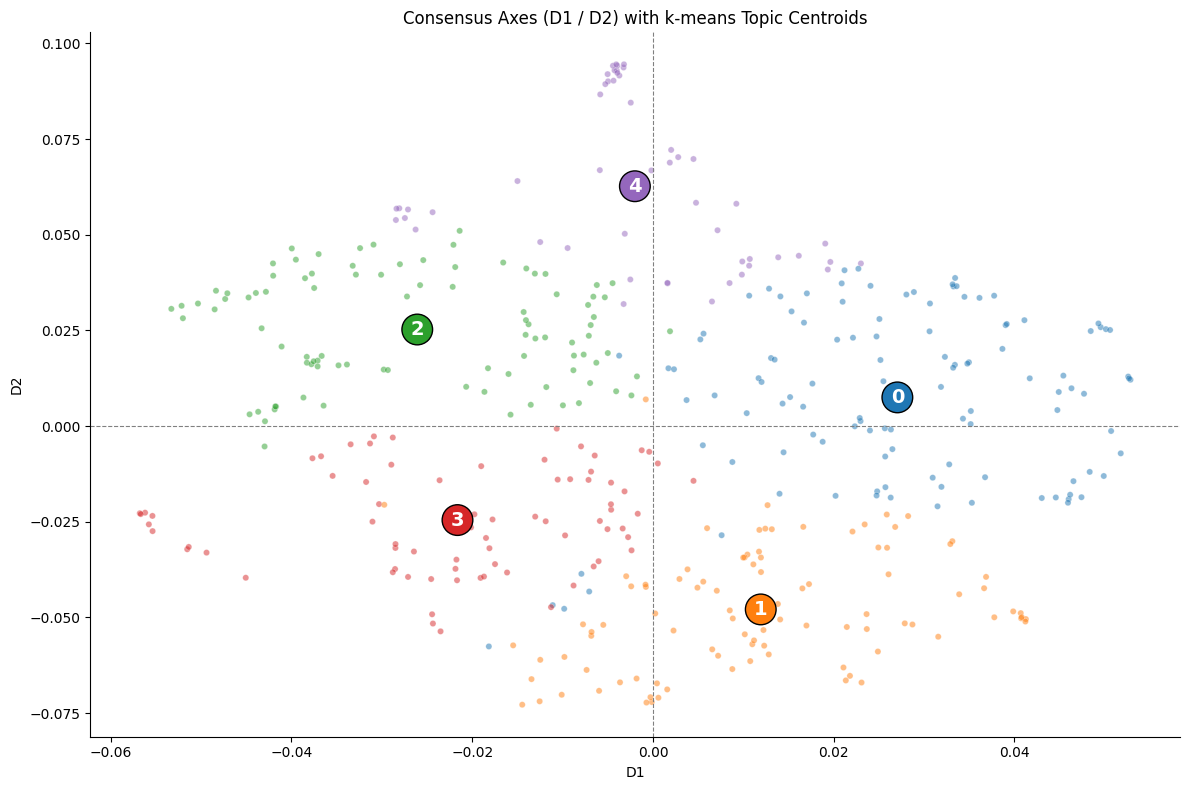

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

df = pd.read_csv("Sections_with_5_topic_consensus_v2.csv")

centroids = (
    df
    .groupby("topic_consensus")[["D1_consensus","D2_consensus"]]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(
    data=df,
    x="D1_consensus", y="D2_consensus",
    hue="topic_consensus", palette="tab10",
    s=20, alpha=0.5, legend=False,
    ax=ax
)

# annotate each centroid
for _, row in centroids.iterrows():
    t = int(row["topic_consensus"])
    x,y = row["D1_consensus"], row["D2_consensus"]
    ax.text(
        x, y, f"{t}", fontsize=14, fontweight="bold",
        ha="center", va="center", color="white",
        bbox=dict(boxstyle="circle,pad=0.3", fc=f"C{t}", ec="black", lw=1)
    )

# ensure ticks only on the remaining spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# draw faint crosshair lines instead of spines
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
ax.axvline(0, color='grey', linewidth=0.8, linestyle='--')

# label axes and add title 
ax.set_xlabel(
    "D1"
)
ax.set_ylabel(
    "D2"
)
ax.set_title("Consensus Axes (D1 / D2) with k-means Topic Centroids")
sns.despine()
plt.tight_layout()
plt.show()

In [16]:
## Calculate range of D1 and D2 values and centroids 

# 1. calculate centroids 
centroids = (
    df
    .groupby("topic_consensus")[["D1_consensus","D2_consensus"]]
    .mean()
    .rename(columns={
        "D1_consensus":"D1_centroid",
        "D2_consensus":"D2_centroid"
    })
)

# 2. Compute min/max per topic
ranges = (
    df
    .groupby("topic_consensus")
    .agg(
        D1_min=("D1_consensus","min"),
        D1_max=("D1_consensus","max"),
        D2_min=("D2_consensus","min"),
        D2_max=("D2_consensus","max"),
    )
)

summary = centroids.join(ranges).reset_index()

display(summary)


,topic_consensus,D1_centroid,D2_centroid,D1_min,D1_max,D2_min,D2_max
0,0,0.027049,0.007498,-0.018159,0.052844,-0.057587,0.041124
1,1,0.011931,-0.047914,-0.029730,0.041271,-0.072816,0.006981
2,2,-0.026081,0.025239,-0.053297,0.001889,-0.005327,0.051033
3,3,-0.021630,-0.024563,-0.056784,0.004489,-0.053647,-0.000663
4,4,-0.001998,0.062685,-0.028444,0.023014,0.031898,0.094539


| Topic | D1<sub>centroid</sub> | D2<sub>centroid</sub> | Qualitative region                       |    Quadrant   |   Dominate RQ  |   
| :---: | :-------------------: | :-------------------: | :--------------------------------------- | :-----------: | :-----------: | 
|   0   |         0.0270        |         0.0075        | Technical engineering discourse  |  I (+D1/+D2)  | NA |
|   1   |         0.0119        |        −0.0479        | Technical & Market/tool‐as‐positive tool |  IV (+D1/−D2) | Utility (RQ2) | 
|   2   |        −0.0261        |         0.0252        | Community & Legal/regulatory concerns    |  II (−D1/+D2) |  Ownership (RQ4) |   
|   3   |        −0.0216        |        −0.0246        | Community & Market/filler discourse      | III (−D1/−D2) |  Threat (RQ1) | 
|   4   |        −0.0020        |         0.0627        | Legal & Regulatory policy discourse      |  II (−D1/+D2) |  Transparency (RQ3) |   

**Table 1.** Consensus-topic centroids on D1/D2, qualitative region, and Lovato et al. research-question mappings. 
- Quadrant refers to the sign of (D1, D2): I = (+, +), II = (-, +), III = (-, -), IV = (+, -) 
- Dominate Lovato et al. Research Questions (RQ) for each topic.
- Topic 0 is specifically about technical engineering terms (*i.e. algorithm details*) and was the only cluster of text <br>not represented by Lovato's et al RQs. 

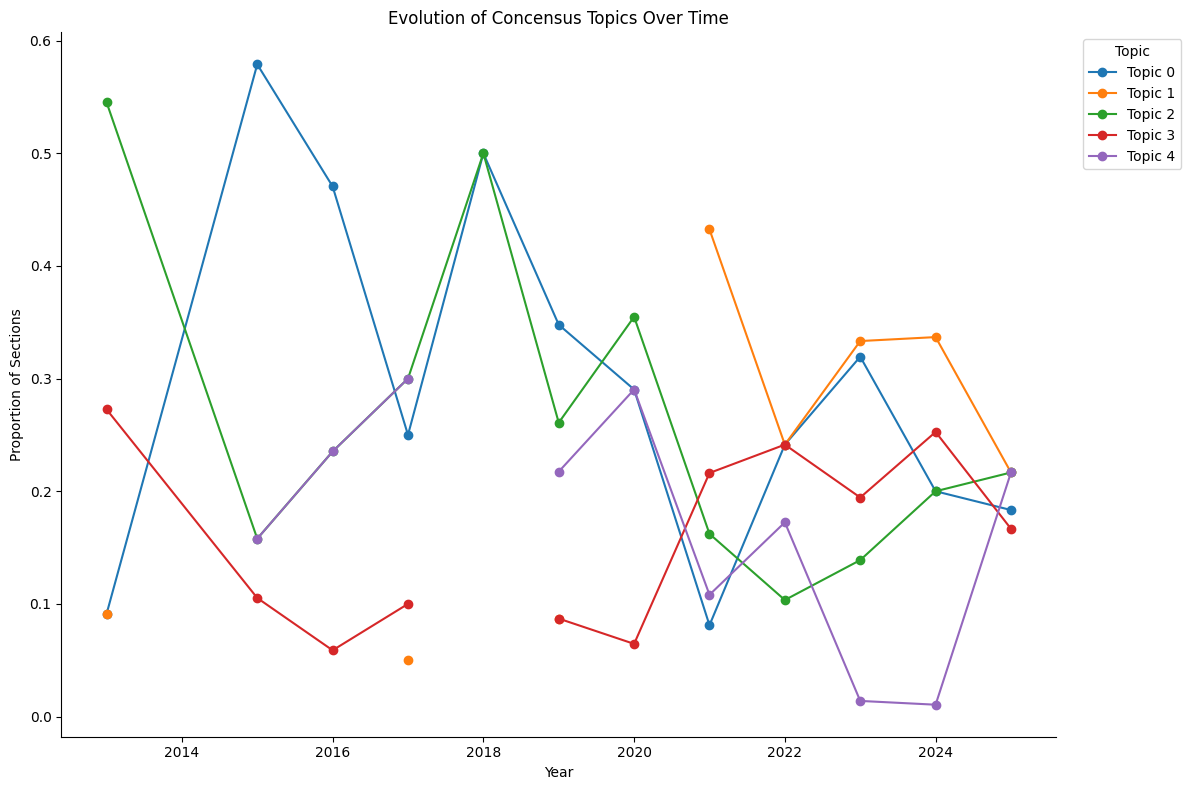

In [17]:
year_topic = (
    df.groupby(['Year', 'topic_consensus'])
    .size().rename("count").reset_index() 
)

year_totals = year_topic.groupby("Year")["count"].sum().rename("total")
year_topic = year_topic.join(year_totals, on = "Year")
year_topic["prop"] = year_topic["count"] / year_topic["total"]

pivot_table_year = year_topic.pivot(index = "Year", columns = "topic_consensus", values = "prop")

plt.figure(figsize = (12, 8))
for topic in pivot_table_year.columns:
    plt.plot(pivot_table_year.index, pivot_table_year[topic], marker = "o", label = f"Topic {topic}")

plt.xlabel("Year")
plt.ylabel("Proportion of Sections")
plt.title("Evolution of Concensus Topics Over Time")
plt.legend(title = "Topic", bbox_to_anchor = (1.02, 1), loc = "upper left")
sns.despine()
plt.tight_layout()
plt.show()

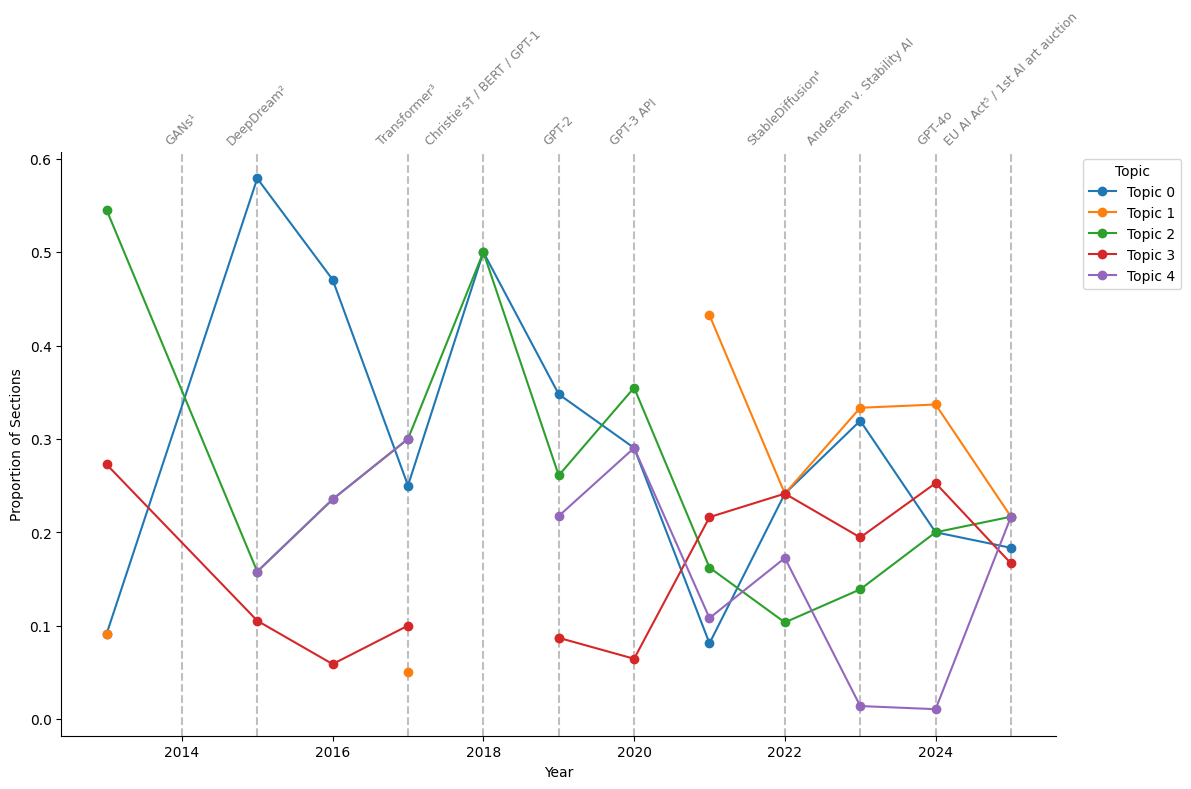

In [18]:

plt.figure(figsize = (12, 8))
ax = plt.gca()

# plot each topic’s timeseries
for topic in pivot_table_year.columns:
    ax.plot(
        pivot_table_year.index,
        pivot_table_year[topic],
        marker="o",
        label=f"Topic {topic}"
    )

# add faint vertical lines & labels for key AI milestones
milestones = {
    2014: "GANs",
    2015: "DeepDream",
    2017: "Transformer",
    #2018: "GPT-1; BERT; AI art auction at Christie's",
    2018: "*1",
    2019: "GPT-2",
    #2020: "GPT-3; Art authorship debates",
    2020: "*2",
    #2022: "ChatGPT; DALL·E 2; Stable Diffusion open-source",
    2022: "*3",
    #2023: "GPT-4; Andersen v Stability AI lawsuit",
    2023: "*4",
    2024: "GPT-4o",
    #2025: "EU AI Act; Christie's first AI auction"
    2025: "*5"
}


# --- 2) Define your milestone years & labels (or footnote codes) ---
milestones2 = {
    2014: "GANs¹",
    2015: "DeepDream²",
    2017: "Transformer³",
    2018: "Christie's† / BERT / GPT-1",
    2019: "GPT-2",
    2020: "GPT-3 API",
    2022: "StableDiffusion⁴",
    2023: "Andersen v. Stability AI",
    2024: "GPT-4o",
    2025: "EU AI Act⁵ / 1st AI art auction"
}

ymin, ymax = ax.get_ylim()
for year, label in milestones2.items():
    ax.axvline(x=year, color="grey", linestyle="--", alpha=0.5, zorder=0)
    # place the label just above the top of the plot, rotated vertically
    ax.text(
        year, ymax + 0.005, 
        label, 
        rotation=45, 
        va="bottom", 
        ha="center",
        fontsize=9,
        color="grey",
        alpha=1
    )

ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Sections")
#ax.set_title("Evolution of Consensus Topics Over Time")
ax.set_title("")

# legend to the right
ax.legend(
    title="Topic", 
    bbox_to_anchor=(1.02, 1), 
    loc="upper left"
)

sns.despine()
plt.tight_layout()
plt.show()

| Year | Event                                               |
| :--: | :-------------------------------------------------- |
| 2014 | GANs introduced (Goodfellow et al.)                 |
| 2015 | Google DeepDream release                            |
| 2017 | Transformer architecture published (Vaswani et al.) |
| 2018 | (*1) AI art auction at Christie’s; BERT release          |
| 2019 | GPT‑2 release                                       |
| 2020 | (*2) GPT‑3 public API; authorship debates                |
| 2022 | (*3) Stable Diffusion open‑source; GPT‑3.5               |
| 2023 | (*4) GPT‑4 release; Andersen v Stability AI lawsuit      |
| 2024 | GPT‑4o multimodal launch                            |
| 2025 | (*5) EU AI Act negotiations; Christie’s first AI auction |

**Table 2.** Key generative AI and art milestones (2014 - 2025) 


## Analysis for paper

Here will be additional analysis that may or may not be needed for the paper. 

For example: 
- sentiment by topic 
- lexical diversity & readability over time 
- section word count & diversity by media type 
- topic distribution by media type and year 
- temporal sentiment trends by topic 
- readability vs axis position 

Also, we can run the following to unpack patterns in our topic and axes: 
- run regression to predict sentiment from axes and topic 
- calculate n-gram richness by axis extreme 

**Questions to try and answer:** 
1. Do multiple metrics peak or dip around the same time / events? 

2. Is there major differences between media sources? Specifically, are some media sources better or worse at representing topics that artists care about? 

3. Does D1 or D2 explain more variance in sentiment or readability than the discrete topics themselves? 

4. Extreme events --> flashpoint events: evidence that these events could be case studies 

5. Regression R^2 results: If D1 / D2 explain a lot of variance in sentiment (i.e. if R^2 > 0.3), there's a substantive finding we can call out and state that future work needs to analyze that further. 

## SENTIMENT 

In [6]:
from transformers import pipeline
from sklearn.linear_model import Ridge

tw_sent = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
#df["tw_sent"] = df["section_text"].apply(lambda t: tw_sent(t[:512])[0]["score"])

/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-13 14:56:19.741461: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-13 14:56:19.741495: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-08-13 14:56:19.741501: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1755111379.741538   72785 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755111379.741576   72785 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci b

In [10]:
df['tw_sent'].describe()

count    430.000000
mean       0.698109
std        0.124112
min        0.431194
25%        0.597633
50%        0.706695
75%        0.790739
max        0.983315
Name: tw_sent, dtype: float64

In [19]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/echoes/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["vader"] = df["section_text"].apply(lambda t: sid.polarity_scores(t)["compound"])

## LANGUAGE METRICS 

In [21]:
from textblob import TextBlob

def tb_scores(text):
    tb = TextBlob(text)
    return pd.Series({
        "tb_polarity": tb.sentiment.polarity,
        "tb_subjectivity": tb.sentiment.subjectivity
    })

df[["tb_polarity","tb_subjectivity"]] = df["section_text"].apply(tb_scores)

In [22]:
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize
import numpy as np 

def section_sentence_stats(text):
    sents = sent_tokenize(text)
    scores = [sid.polarity_scores(s)["compound"] for s in sents]
    return pd.Series({
        "sent_mean": np.mean(scores),
        "sent_std": np.std(scores),
        "sent_min": np.min(scores),
        "sent_max": np.max(scores)
    })

df = pd.concat([df, df["section_text"].apply(section_sentence_stats)], axis=1)

[nltk_data] Downloading package punkt to /Users/echoes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/var/folders/yv/y95m0ts51pl7zc59py5b_ckm0000gn/T/ipykernel_53399/2609580884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


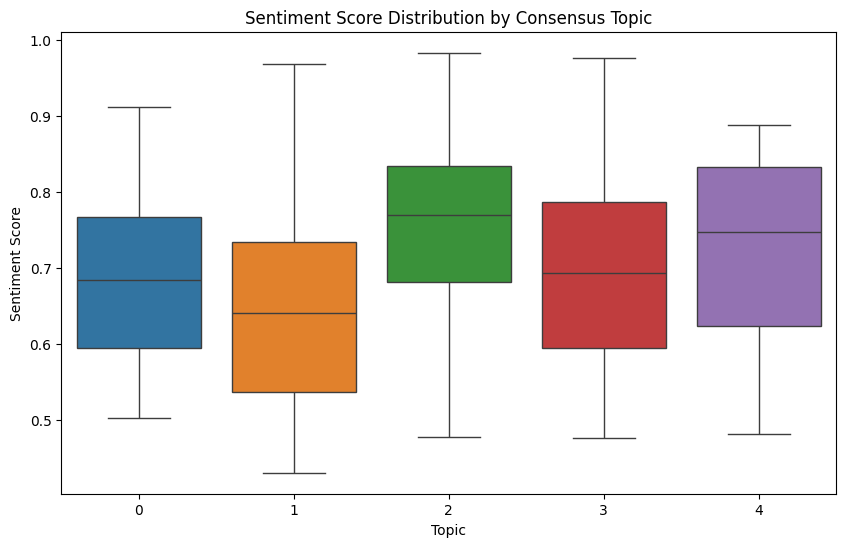

In [158]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x="topic_consensus",
    #y="sentiment_score",
    y="tw_sent",
    palette="tab10"
)
plt.title("Sentiment Score Distribution by Consensus Topic")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.show()

/var/folders/yv/y95m0ts51pl7zc59py5b_ckm0000gn/T/ipykernel_37527/1409340703.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


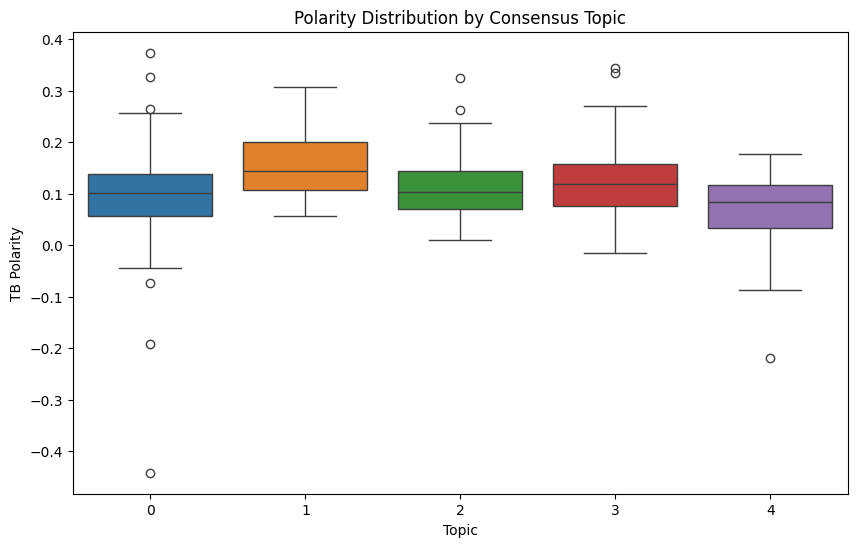

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x="topic_consensus",
    #y="sentiment_score",
    y="tb_polarity",
    palette="tab10"
)
plt.title("Polarity Distribution by Consensus Topic")
plt.xlabel("Topic")
plt.ylabel("TB Polarity")
plt.show()

/var/folders/yv/y95m0ts51pl7zc59py5b_ckm0000gn/T/ipykernel_53399/2714604835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


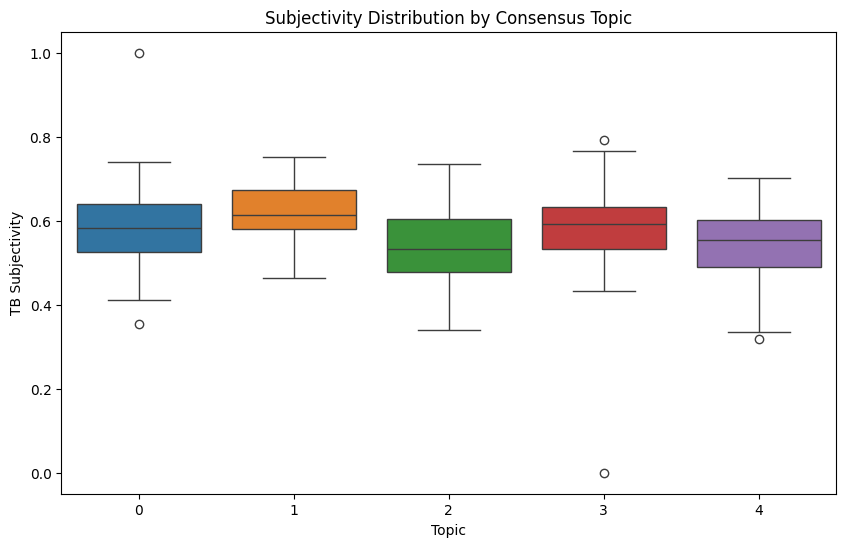

In [86]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x="topic_consensus",
    #y="sentiment_score",
    y="tb_subjectivity",
    palette="tab10"
)
plt.title("Subjectivity Distribution by Consensus Topic")
plt.xlabel("Topic")
plt.ylabel("TB Subjectivity")
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# log transform article_word_count 
df['log_article_word_count'] = np.log1p(df['article_word_count'])

metrics = [
    'tw_sent', #'vader',
       'tb_polarity', 'tb_subjectivity', #'sent_mean',
       'fk_grade',
    #"sentiment_score", 
    "lexical_diversity",
    "log_article_word_count", "D1_consensus", "D2_consensus",
    "prob_consensus"#, "topic_consensus"
]

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])


display(df[metrics].describe())

,tw_sent,tb_polarity,tb_subjectivity,fk_grade,lexical_diversity,log_article_word_count,D1_consensus,D2_consensus,prob_consensus
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,0.483435,0.680493,0.577353,0.820031,0.394562,0.785289,0.517971,0.435099,0.735406
std,0.224791,0.094588,0.088606,0.261663,0.168807,0.208762,0.240434,0.234440,0.125272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301454,0.632956,0.522705,0.763930,0.271028,0.656515,0.351694,0.244472,0.655502
50%,0.498987,0.680162,0.581952,0.956497,0.386293,0.838132,0.498919,0.447210,0.731312
75%,0.651207,0.728143,0.635558,0.971411,0.492961,0.984127,0.709217,0.623935,0.824177
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


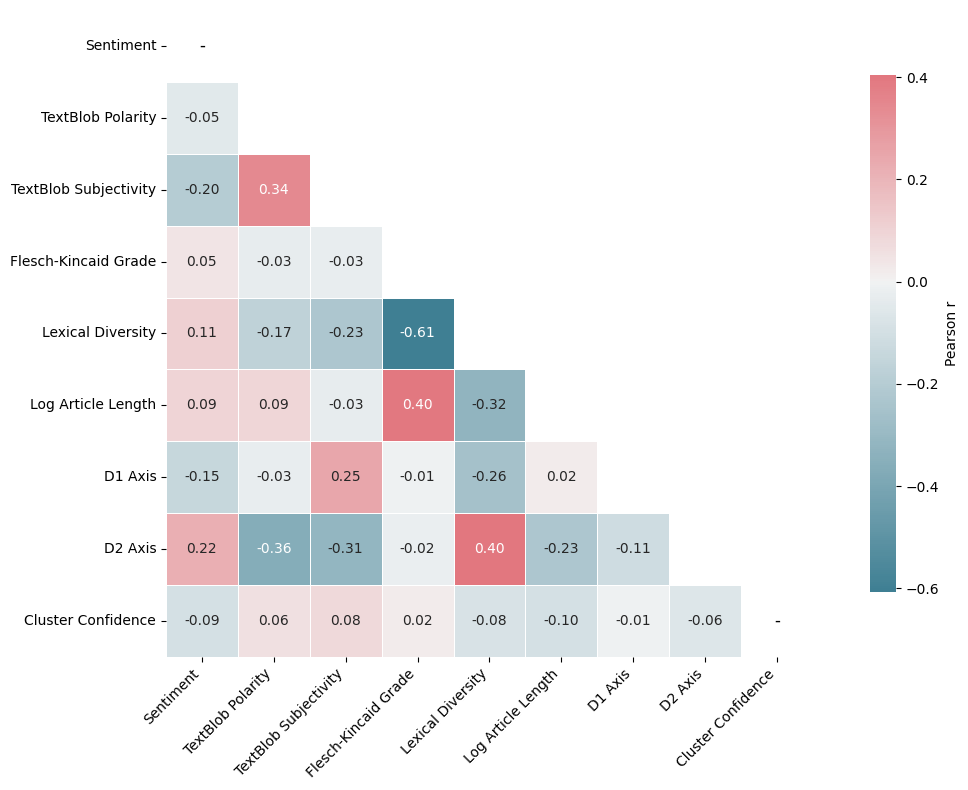

In [19]:
corr = df[metrics].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


# Friendly labels:
friendly = {
    'tw_sent': "Sentiment",
    'tb_polarity': "TextBlob Polarity",
    'tb_subjectivity': "TextBlob Subjectivity",
    'fk_grade': "Flesch-Kincaid Grade",
    'lexical_diversity': "Lexical Diversity",
    'log_article_word_count': "Log Article Length",
    'D1_consensus': "D1 Axis",
    'D2_consensus': "D2 Axis",
    'prob_consensus': "Cluster Confidence"
}

plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(
    corr, mask=mask, cmap=cmap, center=0,
    annot=True, fmt=".2f", annot_kws={"size":10},
    cbar_kws={"shrink":0.8, "label":"Pearson r"},
    square=True, linewidths=0.5
)

# Replace ticklabels:
ax.set_xticklabels([friendly[m.get_text()] for m in ax.get_xticklabels()],
                   rotation=45, ha="right", fontsize=10)
ax.set_yticklabels([friendly[m.get_text()] for m in ax.get_yticklabels()],
                   rotation=0, ha="right", fontsize=10)

# Add “-” on the two diagonal cells you wanted filled
tw_i = metrics.index('tw_sent')
pc_i = metrics.index('prob_consensus')
for i in (tw_i, pc_i):
    ax.text(i+0.5, i+0.5, "-", ha="center", va="center", color="black", fontsize=12)

#ax.set_title("Fig 5. Section-Level Correlations of Linguistic & Topic Metrics", pad=12, fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

| Metric                | Definition                                                                                     |
| --------------------- | ---------------------------------------------------------------------------------------------- |
| Sentiment     | Transformer-based model fine-tuned on Twitter data (e.g. cardiffnlp/twitter-roberta-sentiment) |
| TextBlob Polarity     | TextBlob’s rule-based polarity score (–1 to +1)                                                |
| TextBlob Subjectivity | TextBlob’s rule-based subjectivity score (0 to 1)                                              |
| Flesch-Kincaid Grade  | Textstat’s FK grade level readability metric                                                   |
| Lexical Diversity     | Unique tokens ÷ total tokens per section                                                       |
| Log Article Length    | logₑ(1 + total word count of article)                                                          |
| D1 Axis               | Consensus UMAP-1 coordinate (Artistic to Technical)                                             |
| D2 Axis               | Consensus UMAP-2 coordinate (Market to Legal)                                                   |
| Cluster Confidence    | Normalized distance-to-centroid pseudo-probability from BERTopic                               |

**Table 4.** Metric definitions for *Fig 5. Section-Level Correlations of Linguistic & Topic Metrics.*

## MEDIA TYPE: Distribution across topics 

In [10]:
df['media type'].value_counts()

media type
audio      216
article    156
paper       57
video        1
Name: count, dtype: int64

In [25]:
df = pd.DataFrame(df)

df.loc[df['media type'] == 'video ', 'media type'] = 'audio'

df['media type'].value_counts()

media type
audio      217
article    156
paper       57
Name: count, dtype: int64

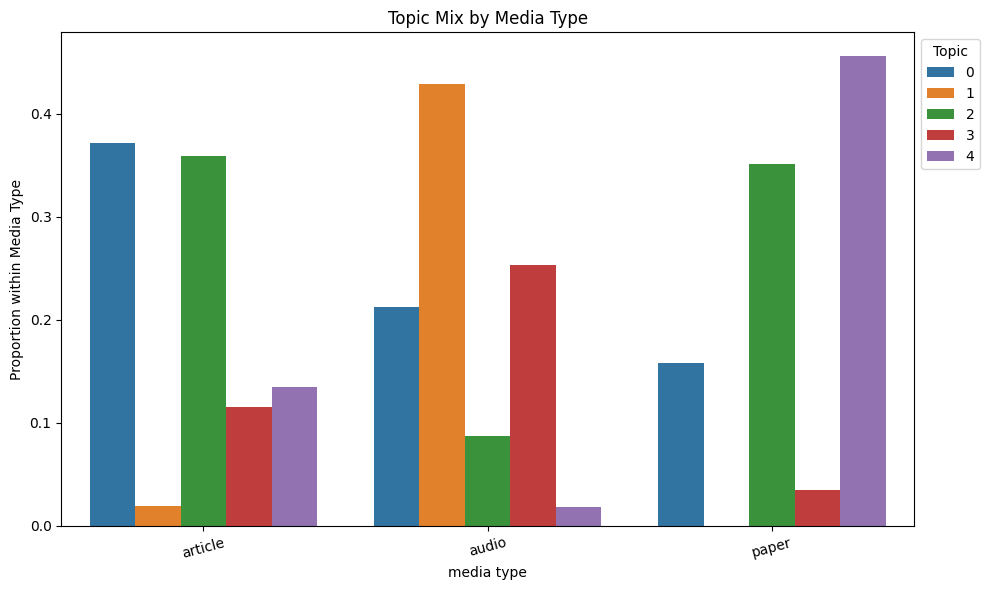

In [26]:
ct = pd.crosstab(
    df["media type"],
    df["topic_consensus"],
    normalize="index"
)
mt = ct.reset_index().melt(
    id_vars="media type",
    var_name="topic_consensus",
    value_name="prop"
)

# 3) plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=mt,
    x="media type", y="prop",
    hue="topic_consensus",
    palette="tab10"
)
plt.legend(title="Topic", bbox_to_anchor=(1,1))
plt.title("Topic Mix by Media Type")
plt.xticks(rotation=15)
plt.ylabel("Proportion within Media Type")
plt.tight_layout()
plt.show()

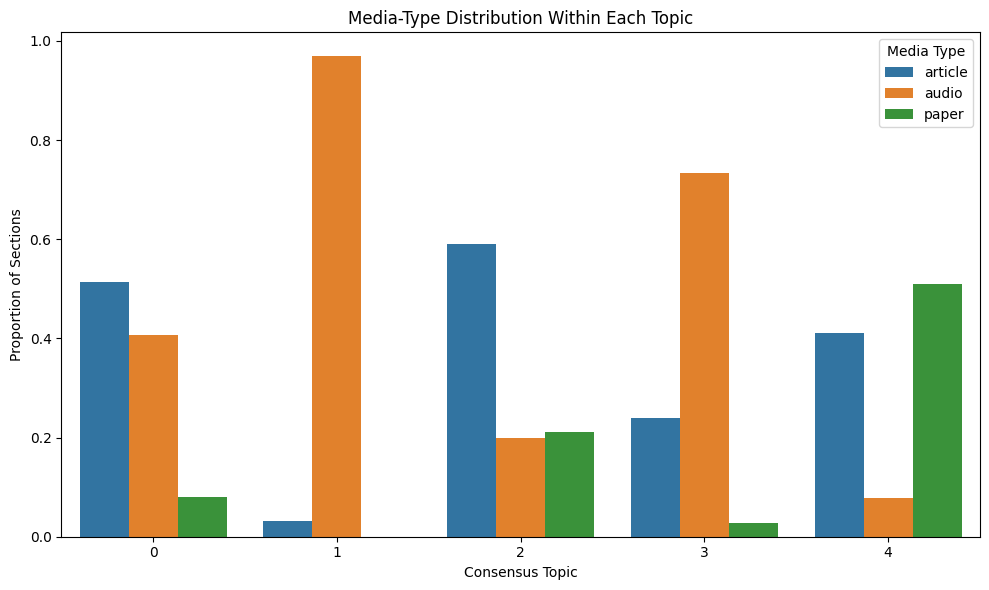

In [28]:
ct = pd.crosstab(
    df["topic_consensus"],   # rows
    df["media type"],        # columns
    normalize="index"                # each row sums to 1
)

# 2) Melt it into long form
mt = (
    ct
    .reset_index()
    .melt(
        id_vars="topic_consensus",
        var_name="media type",
        value_name="prop"
    )
)

# 3) Plot: one bar per topic, colored by media type
plt.figure(figsize=(10,6))
sns.barplot(
    data=mt,
    x="topic_consensus", 
    y="prop",
    hue="media type",
    palette="tab10"
)
plt.xlabel("Consensus Topic")
plt.ylabel("Proportion of Sections")
plt.title("Media-Type Distribution Within Each Topic")
plt.legend(title="Media Type", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [110]:
"""sent_year = (
    df.groupby(["Year","topic_consensus"])["tw_sent"]
      .mean()
      .reset_index()
)
plt.figure(figsize=(12,6))
for t in sorted(df["topic_consensus"].unique()):
    subset = sent_year[sent_year["topic_consensus"] == t]
    plt.plot(subset["Year"], subset["tw_sent"], marker="o", label=f"Topic {t}")
plt.legend(title="Topic")
plt.title("Mean Sentiment by Topic Over Time")
plt.ylabel("Avg. Sentiment Score")
plt.show()
"""

'sent_year = (\n    df.groupby(["Year","topic_consensus"])["tw_sent"]\n      .mean()\n      .reset_index()\n)\nplt.figure(figsize=(12,6))\nfor t in sorted(df["topic_consensus"].unique()):\n    subset = sent_year[sent_year["topic_consensus"] == t]\n    plt.plot(subset["Year"], subset["tw_sent"], marker="o", label=f"Topic {t}")\nplt.legend(title="Topic")\nplt.title("Mean Sentiment by Topic Over Time")\nplt.ylabel("Avg. Sentiment Score")\nplt.show()\n'

In [109]:
"""lexical_year = (
    df.groupby(["Year","topic_consensus"])["lexical_diversity"]
      .mean()
      .reset_index()
)
plt.figure(figsize=(12,6))
for t in sorted(df["topic_consensus"].unique()):
    subset = lexical_year[lexical_year["topic_consensus"] == t]
    plt.plot(subset["Year"], subset["lexical_diversity"], marker="o", label=f"Topic {t}")
plt.legend(title="Topic")
plt.title("Mean Lexical Diversity by Topic Over Time")
plt.ylabel("Avg. Lexical Diversity")
plt.show()"""

'lexical_year = (\n    df.groupby(["Year","topic_consensus"])["lexical_diversity"]\n      .mean()\n      .reset_index()\n)\nplt.figure(figsize=(12,6))\nfor t in sorted(df["topic_consensus"].unique()):\n    subset = lexical_year[lexical_year["topic_consensus"] == t]\n    plt.plot(subset["Year"], subset["lexical_diversity"], marker="o", label=f"Topic {t}")\nplt.legend(title="Topic")\nplt.title("Mean Lexical Diversity by Topic Over Time")\nplt.ylabel("Avg. Lexical Diversity")\nplt.show()'

## LEXICAL DIVERSITY 

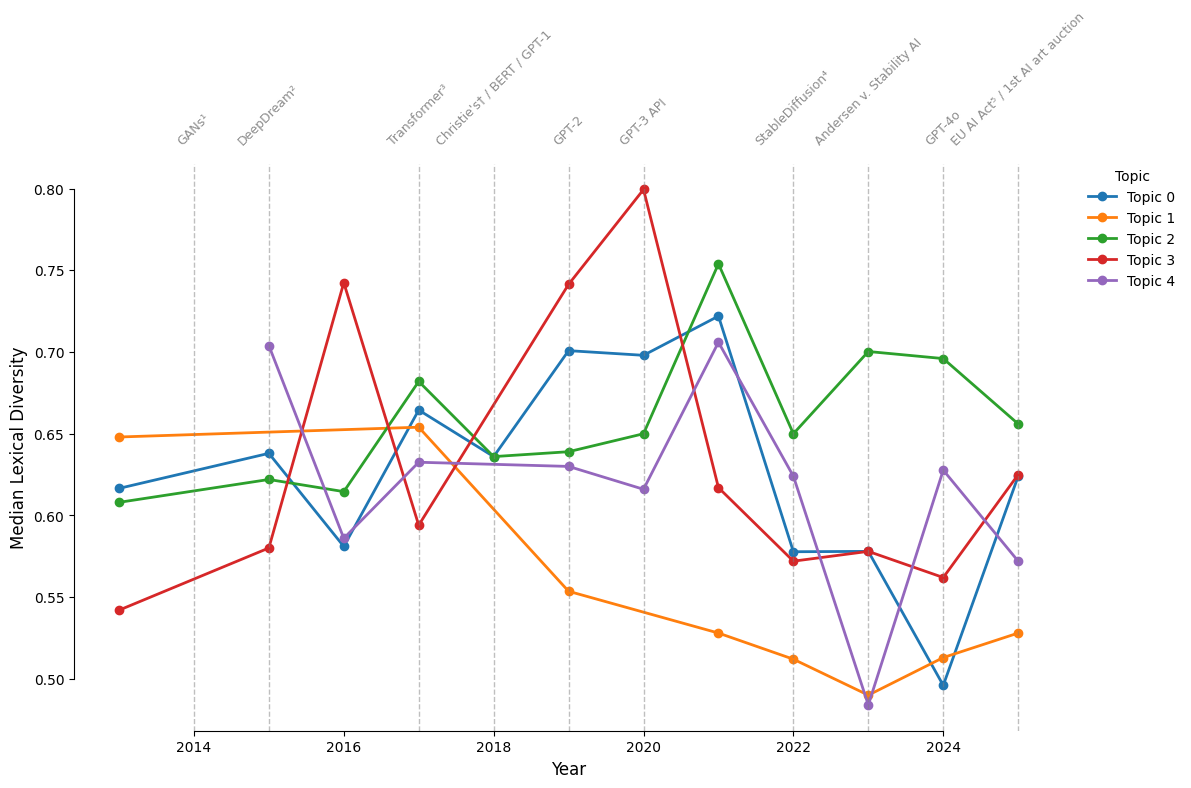

In [29]:
lexical_year = (
    df.groupby(["Year","topic_consensus"])["lexical_diversity"]
      .median()
      .reset_index()
)

# add faint vertical lines & labels for key AI milestones
milestones = {
    2014: "GANs",
    2015: "DeepDream",
    2017: "Transformer",
    #2018: "GPT-1; BERT; AI art auction at Christie's",
    2018: "*1",
    2019: "GPT-2",
    #2020: "GPT-3; Art authorship debates",
    2020: "*2",
    #2022: "ChatGPT; DALL·E 2; Stable Diffusion open-source",
    2022: "*3",
    #2023: "GPT-4; Andersen v Stability AI lawsuit",
    2023: "*4",
    2024: "GPT-4o",
    #2025: "EU AI Act; Christie's first AI auction"
    2025: "*5"
}


# --- 2) Define your milestone years & labels (or footnote codes) ---
milestones2 = {
    2014: "GANs¹",
    2015: "DeepDream²",
    2017: "Transformer³",
    2018: "Christie's† / BERT / GPT-1",
    2019: "GPT-2",
    2020: "GPT-3 API",
    2022: "StableDiffusion⁴",
    2023: "Andersen v. Stability AI",
    2024: "GPT-4o",
    2025: "EU AI Act⁵ / 1st AI art auction"
}


# --- 3) Plot setup ---
fig, ax = plt.subplots(figsize=(12, 8))

palette = sns.color_palette("tab10", n_colors=5)
for topic in sorted(lexical_year["topic_consensus"].unique()):
    the_topic = int(topic)
    sub = lexical_year[lexical_year["topic_consensus"] == topic]
    ax.plot(
        sub["Year"], sub["lexical_diversity"],
        marker="o", linewidth=2, markersize=6,
        color=palette[the_topic],
        label=f"Topic {the_topic}"
    )

# --- 4) Add the faint vertical milestone lines and annotations ---
ymin, ymax = ax.get_ylim()
for year, label in milestones2.items():
    ax.axvline(year, color="gray", linestyle="--", linewidth=1, alpha=0.5)
    ax.text(
        year, ymax + 0.01,  # just above the top of the line
        label,
        rotation=45,
        verticalalignment="bottom",
        horizontalalignment="center",
        fontsize=9,
        color="gray",
        alpha=0.9
    )

# --- 5) Final styling ---
#ax.set_title("Fig 4. Median Lexical Diversity by Topic Over Time", fontsize=14, pad=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Median Lexical Diversity", fontsize=12)

# move legend outside to the right
ax.legend(
    title="Topic", 
    bbox_to_anchor=(1.02, 1), 
    loc="upper left", 
    borderaxespad=0, 
    frameon=False
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

## READABILITY 

/var/folders/yv/y95m0ts51pl7zc59py5b_ckm0000gn/T/ipykernel_5210/3456866911.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x="Year", y="fk_grade", ci="sd")


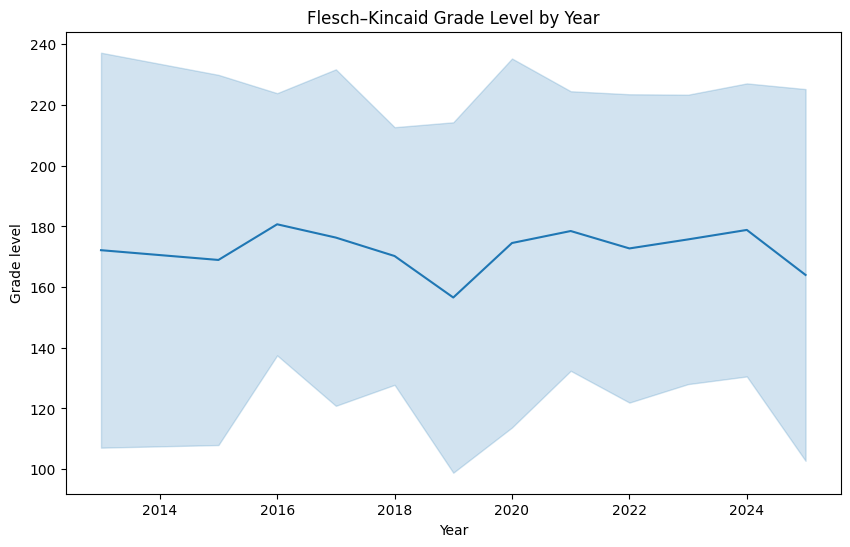

In [30]:
# (b) Add Flesch–Kincaid readability via textstat
import textstat
df["fk_grade"] = df["section_text"].apply(textstat.flesch_kincaid_grade)

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Year", y="fk_grade", ci="sd")
plt.title("Flesch–Kincaid Grade Level by Year")
plt.ylabel("Grade level")
plt.show()

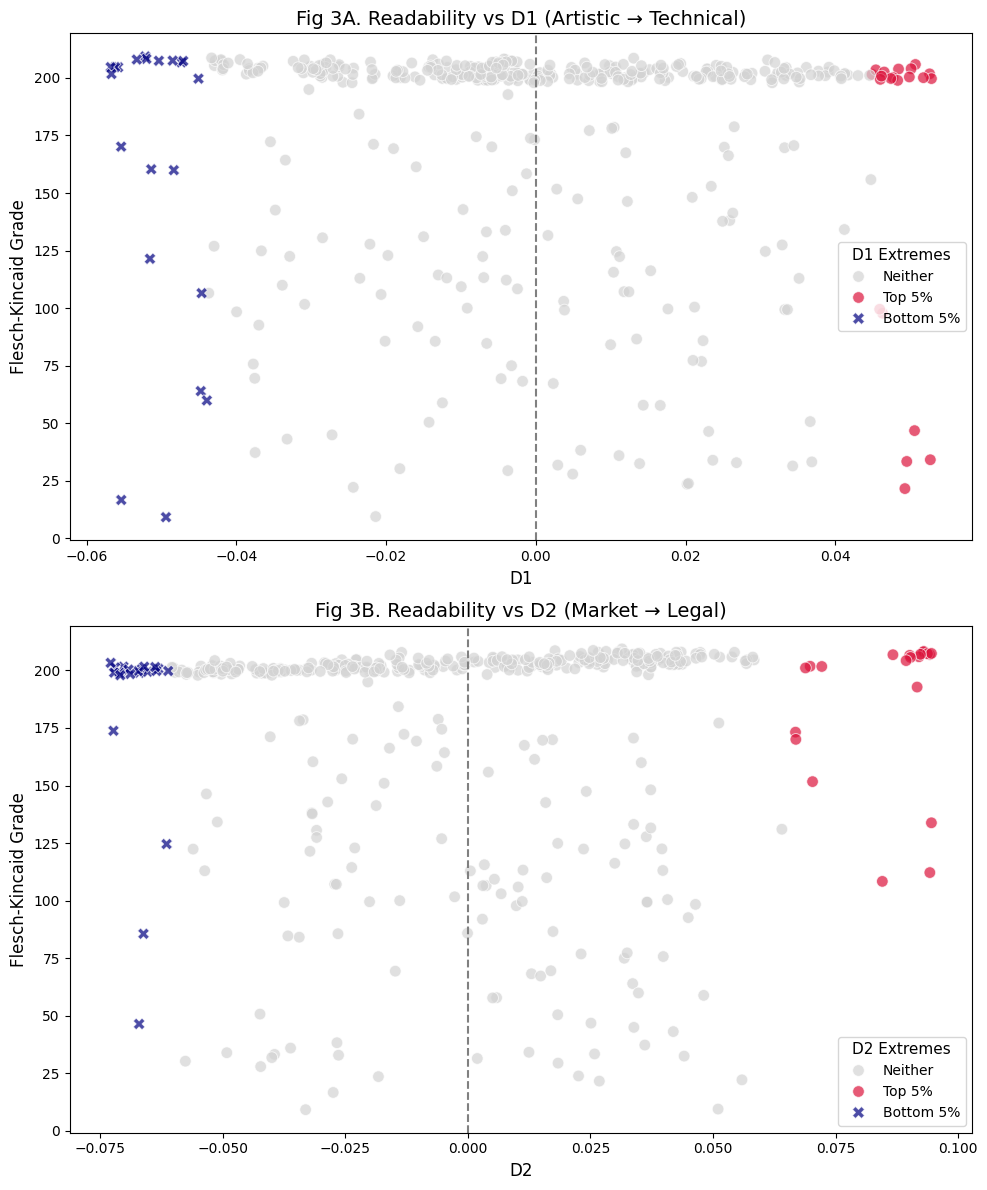

In [31]:

# 1) Build a single “highlight” column for each axis
df["Highlight D1"] = np.where(
    df["top5_D1_consensus"] == 1, "Top 5%", 
    np.where(df["bottom5_D1_consensus"] == 1, "Bottom 5%", "Neither")
)
df["Highlight D2"] = np.where(
    df["top5_D2_consensus"] == 1, "Top 5%", 
    np.where(df["bottom5_D2_consensus"] == 1, "Bottom 5%", "Neither")
)

# 2) Define a shared palette + marker mapping
pal = {"Neither":"lightgray", "Top 5%":"crimson", "Bottom 5%":"navy"}
mks = {"Neither":"o",       "Top 5%":"o",       "Bottom 5%":"X"}

# 3) Create two stacked subplots of identical width
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=False)

# --- Fig 3A: Readability vs D1 ---
sns.scatterplot(
    data=df, x="D1_consensus", y="fk_grade",
    hue="Highlight D1", style="Highlight D1",
    palette=pal, markers=mks,
    s=70, alpha=0.7, ax=ax1
)
ax1.axvline(0, color="gray", linestyle="--")
ax1.set_title("Fig 3A. Readability vs D1 (Artistic → Technical)", fontsize=14)
ax1.set_xlabel("D1", fontsize = 12)  # no xlabel on top panel
ax1.set_ylabel("Flesch-Kincaid Grade", fontsize=12)
ax1.legend(title="D1 Extremes", fontsize=10, title_fontsize=11, loc="right")

# --- Fig 3B: Readability vs D2 ---
sns.scatterplot(
    data=df, x="D2_consensus", y="fk_grade",
    hue="Highlight D2", style="Highlight D2",
    palette=pal, markers=mks,
    s=70, alpha=0.7, ax=ax2
)
ax2.axvline(0, color="gray", linestyle="--")
ax2.set_title("Fig 3B. Readability vs D2 (Market → Legal)", fontsize=14)
ax2.set_xlabel("D2", fontsize=12)
ax2.set_ylabel("Flesch-Kincaid Grade", fontsize=12)
ax2.legend(title="D2 Extremes", fontsize=10, title_fontsize=11, loc="lower right")

plt.tight_layout()
plt.show()

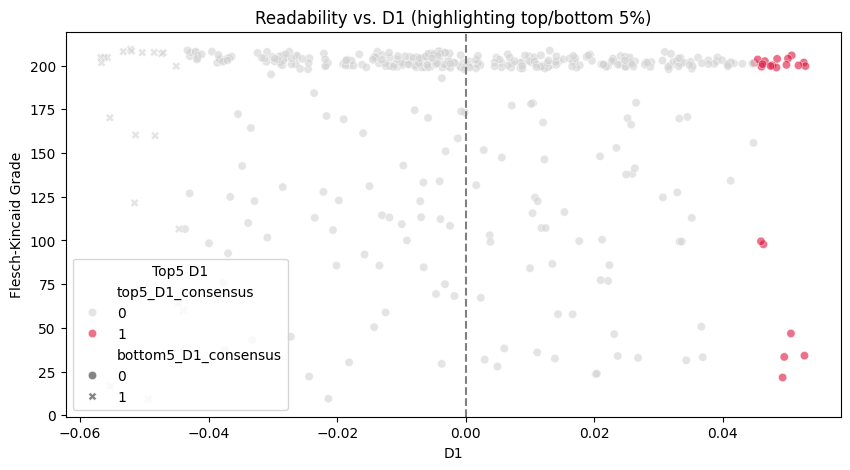

In [32]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x="D1_consensus", y="fk_grade",
    hue="top5_D1_consensus",
    style="bottom5_D1_consensus",
    palette=["lightgray","crimson"],
    alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Readability vs. D1 (highlighting top/bottom 5%)")
plt.xlabel("D1")
plt.ylabel("Flesch-Kincaid Grade")
plt.legend(title="Top5 D1")
plt.show()


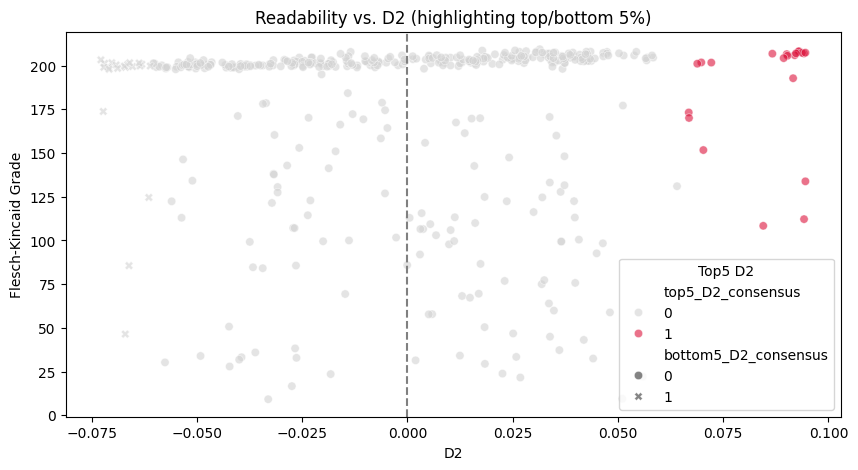

In [33]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x="D2_consensus", y="fk_grade",
    hue="top5_D2_consensus",
    style="bottom5_D2_consensus",
    palette=["lightgray","crimson"],
    alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Readability vs. D2 (highlighting top/bottom 5%)")
plt.xlabel("D2")
plt.ylabel("Flesch-Kincaid Grade")
plt.legend(title="Top5 D2")
plt.show()


In [34]:
import statsmodels.formula.api as smf

# encode topic as categorical
df["topic_consensus_cat"] = df["topic_consensus"].astype("category")

model = smf.ols(
    "lexical_diversity ~ D1_consensus + D2_consensus + C(topic_consensus_cat) + Year",
    #"lexical_diversity ~ D1_consensus + D2_consensus + Year",
    data=df
).fit()
display(model.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      lexical_diversity   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     20.51
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           9.79e-24
Time:                        15:00:10   Log-Likelihood:                 408.85
No. Observations:                 430   AIC:                            -801.7
Df Residuals:                     422   BIC:                            -769.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.5270      3.088      1.466      0.143      -1.543      10.597
C(topic_consensus_cat)[T.1]    -0.0182      0.020     -0.915      0.361      -0.057       0.021
C(topic_consensus_cat)[T.2]    -0.0247      0.021     -1.153      0.249      -0.067       0.017
C(topic_consensus_cat)[T.3]    -0.0281      0.021     -1.315      0.189      -0.070       0.014
C(topic_consensus_cat)[T.4]    -0.0895      0.024     -3.753      0.000      -0.136      -0.043
D1_consensus                   -1.1722      0.299     -3.922      0.000      -1.760      -0.585
D2_consensus                    1.2932      0.271      4.779      0.000       0.761       1.825
Year                           -0.0019      0.002     -1.260      0.208      -0.005       0.001
==============================================================================
Omnibus:                       66.314   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.398
Skew:                           0.929   Prob(JB):                     1.07e-24
Kurtosis:                       4.645   Cond. No.                     1.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(1,2), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english")
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).A1)
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:top_k]

# e.g. top bi-grams in top5_D1_consensus
top5bigrams = top_ngrams(
    df.loc[df.top5_D1_consensus==1, "section_text"],
    ngram_range=(2,2)
)
print("Top 20 bi-grams in top-5% D1:", top5bigrams)

Top 20 bi-grams in top-5% D1: [('et al', 30), ('neural network', 28), ('deep dream', 22), ('ai art', 17), ('generate image', 12), ('look like', 12), ('mental image', 12), ('dream algorithm', 11), ('deep learning', 10), ('thing like', 10), ('gradient ascent', 9), ('input image', 9), ('little bit', 9), ('artificial neural', 8), ('like human', 8), ('math function', 8), ('abstract idea', 7), ('al 2013', 7), ('image image', 7), ('artistically interesting', 6)]


In [36]:

# e.g. top bi-grams in top5_D1_consensus
top5bigrams = top_ngrams(
    df.loc[df.top5_D2_consensus==1, "section_text"],
    ngram_range=(2,2)
)
print("Top 20 bi-grams in top-5% D2:", top5bigrams)

Top 20 bi-grams in top-5% D2: [('artificial intelligence', 39), ('copyright law', 34), ('copyright protection', 33), ('piece art', 21), ('supra note', 21), ('copyright office', 19), ('creative robot', 19), ('2025 report', 17), ('ai art', 16), ('copyright coverage', 16), ('copyright ownership', 15), ('ai tool', 13), ('human authorship', 12), ('art create', 11), ('copyright doctrine', 11), ('grant copyright', 11), ('concept originality', 10), ('copyright work', 10), ('intellectual property', 10), ('visual art', 10)]


In [37]:

# e.g. top bi-grams in top5_D1_consensus
bottom5bigrams = top_ngrams(
    df.loc[df.bottom5_D1_consensus==1, "section_text"],
    ngram_range=(2,2)
)
print("Top 20 bi-grams in bottom-5% D1:", bottom5bigrams)

Top 20 bi-grams in bottom-5% D1: [('ai art', 13), ('neural network', 10), ('mr eck', 9), ('artificial intelligence', 8), ('human artist', 8), ('ai technology', 7), ('art world', 7), ('human creativity', 7), ('machine learning', 7), ('40 united', 6), ('acreative common', 6), ('ai music', 6), ('artist ai', 6), ('attributionnoncommercial 40', 6), ('common attributionnoncommercial', 6), ('cultural infrastructure', 6), ('goldberg say', 6), ('license acreative', 6), ('states license', 6), ('united states', 6)]


In [38]:

# e.g. top bi-grams in top5_D1_consensus
bottom5bigrams = top_ngrams(
    df.loc[df.bottom5_D2_consensus==1, "section_text"],
    ngram_range=(2,2)
)
print("Top 20 bi-grams in bottom-5% D2:", bottom5bigrams)

Top 20 bi-grams in bottom-5% D2: [('digital art', 28), ('know like', 24), ('like know', 21), ('know know', 18), ('feel like', 17), ('like like', 17), ('think know', 17), ('know think', 14), ('artist know', 13), ('little bit', 13), ('right like', 12), ('ai art', 11), ('art world', 11), ('think like', 10), ('yeah yeah', 10), ('art market', 9), ('say like', 9), ('sort like', 9), ('art like', 8), ('digital artist', 8)]


## (1) Zero-shot, multi-label NLI with 3 label sets per RQ 

In [39]:
from transformers import pipeline
from tqdm import tqdm

# If you already have df, we’ll write into it. Expect a column: df["section_text"]

# 1) Three phrasing sets (A/B/C), one label per RQ in each set.
#    These paraphrase Lovato et al. (2024) RQs and responses.

LABEL_SETS = {
    "A": {
        "Threat":       "AI models threaten artists' jobs and livelihoods",
        "Utility":      "AI is a useful creative tool for artists",
        "Transparency": "Training data and model provenance should be transparent",
        "Ownership":    "Ownership and copyright of AI-generated art are contested"
    },
    "B": {
        "Threat":       "Generative AI harms the art workforce and creative labor",
        "Utility":      "Generative AI benefits artistic practice and productivity",
        "Transparency": "Developers should disclose training datasets in detail",
        "Ownership":    "AI art raises unresolved questions of intellectual property"
    },
    "C": {
        "Threat":       "Automation could replace human artists and undercut wages",
        "Utility":      "AI tools augment artists' workflows and creativity",
        "Transparency": "Consent, attribution, and dataset disclosure are required",
        "Ownership":    "Who owns derivative AI artworks is disputed"
    }
}

# 2) Zero-shot classifier. 
#    Tip: set device=0 for GPU; use device=-1 for CPU.
zshot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=-1)

def _renorm_to_probs(scores: dict, keys=("Threat","Utility","Transparency","Ownership"), temperature=1.0):
    """
    Take dict of raw scores for 4 labels, temperature-softmax, return a vector that sums to 1.
    """
    vec = np.array([scores[k] for k in keys], dtype=float)
    vec = vec / max(vec.max(), 1e-9)  # optional scale
    vec = vec / temperature
    ex = np.exp(vec - vec.max())
    p = ex / (ex.sum() + 1e-9)
    return dict(zip(keys, p))

def nli_scores_for_set(text, labels_dict):
    """
    Run zero-shot for one label set (4 labels), return renormalized probs per RQ.
    """
    labels = list(labels_dict.values())
    out = zshot(text[:1000], labels, multi_label=True)  # truncate long sections for speed
    # Map back to exact label strings
    score_map = dict(zip(out["labels"], out["scores"]))
    # Convert to canonical keys Threat/Utility/Transparency/Ownership
    raw = {k: score_map[labels_dict[k]] for k in ["Threat","Utility","Transparency","Ownership"]}
    return _renorm_to_probs(raw)

def nli_all_sets(text):
    """
    Run sets A, B, C → return:
      per-set probs and median probs across the 3 sets.
    """
    ps = {}
    for setname in ["A","B","C"]:
        ps[setname] = nli_scores_for_set(text, LABEL_SETS[setname])
    # Stack into arrays in canonical order
    keys = ["Threat","Utility","Transparency","Ownership"]
    M = np.vstack([[ps[s][k] for k in keys] for s in ["A","B","C"]])  # shape (3,4)
    median = M.median(axis=0) if isinstance(M, pd.DataFrame) else np.median(M, axis=0)
    median = dict(zip(keys, median))
    return ps, median

# 3) Apply to your corpus with progress bar; write per-set and median columns.
cols_per_set = []
for setname in ["A","B","C"]:
    for k in ["Threat","Utility","Transparency","Ownership"]:
        cols_per_set.append(f"p_{k.lower()}_nli_{setname}")

median_cols = [f"p_{k.lower()}_nli_med" for k in ["Threat","Utility","Transparency","Ownership"]]

# Initialize empty arrays to collect results (faster than repeated df.assign)
P_sets = {c: [] for c in cols_per_set}
P_med  = {c: [] for c in median_cols}

for text in tqdm(df["section_text"], desc="NLI scoring (3 sets + median)"):
    ps, med = nli_all_sets(text)
    # per-set
    for setname in ["A","B","C"]:
        for k in ["Threat","Utility","Transparency","Ownership"]:
            P_sets[f"p_{k.lower()}_nli_{setname}"].append(ps[setname][k])
    # median
    for k, col in zip(["Threat","Utility","Transparency","Ownership"], median_cols):
        P_med[col].append(med[k])

# Write columns back
for c in cols_per_set:
    df[c] = P_sets[c]
for c in median_cols:
    df[c] = P_med[c]

# Optionally normalize the 4 median columns to sum to 1 per row
med_mat = df[median_cols].values
med_mat = med_mat / (med_mat.sum(axis=1, keepdims=True) + 1e-9)
df[[*median_cols]] = med_mat

Device set to use cpu
NLI scoring (3 sets + median): 100%|██████████| 430/430 [34:52<00:00,  4.87s/it]


## (2) Prototype similarity scoring 

Using 5 prototypes per RQ and taking median per RQ. 

In [42]:
# ────────────────────────────────────────────────────────────────────────────
# PROTOTYPE SIMILARITY SCORING (5 prototypes per RQ) → median similarities
# ────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

# Use your existing embedding_model if present; else fall back to mpnet.
try:
    emb_model
except NameError:
    emb_model = SentenceTransformer("all-mpnet-base-v2")

# 1) Five prototypes per RQ (crafted from Lovato et al. 2024 themes)
PROTOTYPES = {
    "Threat": [
        "AI systems threaten artists' jobs and creative livelihoods.",
        "Automation displaces human illustrators and undercuts wages.",
        "Generative models devalue original artwork and labor.",
        "Non-consensual scraping harms working artists.",
        "Artists fear replacement by AI tools in the marketplace."
    ],
    "Utility": [
        "Artists use AI as a creative tool to explore ideas.",
        "Models help speed up workflows and prototyping.",
        "Generative systems can augment, not replace, artistic practice.",
        "AI assists with iteration and expands creative possibilities.",
        "Some artists report productivity gains using AI tools."
    ],
    "Transparency": [
        "Developers should disclose the training images used by their models.",
        "Artists demand detailed transparency about datasets and provenance.",
        "Consent and opt-out mechanisms are necessary for fair use.",
        "Training data and licenses must be clearly documented.",
        "Auditing and watermarking are needed for accountability."
    ],
    "Ownership": [
        "Who owns derivative works created with AI remains contested.",
        "Copyright and licensing of AI-generated art are unresolved.",
        "Artists argue for rights over style-mimicking outputs.",
        "Attribution and fair compensation are central ownership concerns.",
        "Legal disputes focus on authorship of AI-assisted creations."
    ]
}

# 2) Pre-embed and L2-normalize all prototypes (saves time)
proto_embs = {
    rq: emb_model.encode(sents, normalize_embeddings=True)
    for rq, sents in PROTOTYPES.items()
}

def proto_median_probs(text):
    """
    For a section:
      - embed text
      - compute cosine similarity to each of the 5 prototypes per RQ
      - take the *median* similarity per RQ
      - renormalize across the 4 RQs to sum to 1
    Returns a dict of p_<rq>_proto_med.
    """
    text = (text or "")[:1000]
    if not text.strip():
        return pd.Series({
            "p_threat_proto_med": 0.25,
            "p_utility_proto_med": 0.25,
            "p_transparency_proto_med": 0.25,
            "p_ownership_proto_med": 0.25,
        })
    
    v = emb_model.encode(text[:1000], normalize_embeddings=True)
    meds = {}
    for rq, E in proto_embs.items():
        sims = util.cos_sim(v, E).cpu().numpy().ravel()  # shape (5,)
        meds[rq] = float(np.median(sims))
    # shift to positive & renormalize
    vec = np.array([meds["Threat"], meds["Utility"], meds["Transparency"], meds["Ownership"]], dtype=float)
    vec = vec - vec.min()  # make non-negative
    vec = vec / (vec.sum() + 1e-9)
    return pd.Series({
        "p_threat_proto_med": vec[0],
        "p_utility_proto_med": vec[1],
        "p_transparency_proto_med": vec[2],
        "p_ownership_proto_med": vec[3],
    })

# 3) Apply to df
#df[["p_threat_proto_med","p_utility_proto_med","p_transparency_proto_med","p_ownership_proto_med"]] = (
#    tqdm(df["section_text"].apply(proto_median_probs), total=len(df), desc="Prototype median sims")
#)

from tqdm.auto import tqdm
tqdm.pandas(desc="Prototype median sims")

texts = df["section_text"].fillna("")
proto_df = texts.progress_apply(proto_median_probs)   # Series of Series
#proto_df = pd.DataFrame(proto_df.tolist())            # force to DataFrame

df = df.join(proto_df)


Prototype median sims: 100%|██████████| 430/430 [00:09<00:00, 47.03it/s]


In [44]:
df.columns

Index(['Line Number', 'Year', 'Article Name', 'media type', 'section_id',
       'section_text', 'section_word_count', 'cleaner_text', 'embedding_500',
       'topics_model_1', 'topics_model_2', 'topics_model_3', 'topics_model_4',
       'topics_model_5', 'probs_model_1', 'probs_model_2', 'probs_model_3',
       'probs_model_4', 'probs_model_5', 'topic_model_1_2k',
       'topic_model_2_2k', 'topic_model_3_2k', 'topic_model_4_2k',
       'topic_model_5_2k', 'probs_model_1_2k', 'probs_model_2_2k',
       'probs_model_3_2k', 'probs_model_4_2k', 'probs_model_5_2k',
       'sentiment_label', 'sentiment_score', 'lexical_diversity',
       'article_word_count', 'D1_consensus', 'D2_consensus', 'topic_consensus',
       'prob_consensus', 'top5_D1_consensus', 'bottom5_D1_consensus',
       'top5_D2_consensus', 'bottom5_D2_consensus', 'vader', 'tb_polarity',
       'tb_subjectivity', 'sent_mean', 'sent_std', 'sent_min', 'sent_max',
       'fk_grade', 'Highlight D1', 'Highlight D2', 'topic_consen

In [45]:
df.to_csv("Sections_with_5_topics_and_nli_and_proto.csv", index = False)


In [52]:
df[['p_threat_nli_A', 'p_utility_nli_A', 'p_transparency_nli_A',
       'p_ownership_nli_A', 'p_threat_nli_B', 'p_utility_nli_B',
       'p_transparency_nli_B', 'p_ownership_nli_B', 'p_threat_nli_C',
       'p_utility_nli_C', 'p_transparency_nli_C', 'p_ownership_nli_C',
       'p_threat_nli_med', 'p_utility_nli_med', 'p_transparency_nli_med',
       'p_ownership_nli_med', 'p_threat_proto_med', 'p_utility_proto_med',
       'p_transparency_proto_med', 'p_ownership_proto_med']].describe()

,p_threat_nli_A,p_utility_nli_A,p_transparency_nli_A,p_ownership_nli_A,p_threat_nli_B,p_utility_nli_B,p_transparency_nli_B,p_ownership_nli_B,p_threat_nli_C,p_utility_nli_C,p_transparency_nli_C,p_ownership_nli_C,p_threat_nli_med,p_utility_nli_med,p_transparency_nli_med,p_ownership_nli_med,p_threat_proto_med,p_utility_proto_med,p_transparency_proto_med,p_ownership_proto_med
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,0.161044,0.311016,0.316083,0.211857,0.151503,0.322512,0.274284,0.251700,0.175962,0.321817,0.291042,0.211178,0.162395,0.321152,0.295576,0.220876,0.282683,0.432844,0.009953,0.274520
std,0.037645,0.089373,0.075818,0.068795,0.038293,0.075466,0.070132,0.069925,0.054494,0.092508,0.083059,0.059291,0.037940,0.083272,0.071242,0.063053,0.069602,0.099213,0.072109,0.095106
min,0.112830,0.123050,0.142960,0.128643,0.112391,0.125899,0.146475,0.142497,0.117816,0.132017,0.143440,0.134049,0.117180,0.129572,0.148995,0.146040,0.000000,0.000000,0.000000,0.000000
25%,0.143600,0.232511,0.254616,0.166221,0.132653,0.275823,0.223424,0.190223,0.148985,0.240671,0.223179,0.172477,0.144256,0.249674,0.238695,0.175263,0.251835,0.399616,0.000000,0.233101
50%,0.153545,0.319090,0.309939,0.181617,0.141641,0.337475,0.259299,0.237469,0.161869,0.336950,0.265840,0.186769,0.153519,0.335609,0.278105,0.193715,0.290488,0.434853,0.000000,0.268534
75%,0.164805,0.390441,0.376967,0.235725,0.155156,0.380064,0.312401,0.306955,0.174796,0.405136,0.361371,0.228009,0.163934,0.393208,0.345099,0.251254,0.320383,0.478968,0.000000,0.310764
max,0.397213,0.462857,0.467664,0.447059,0.375213,0.462374,0.458206,0.454366,0.443415,0.469496,0.468219,0.439205,0.401641,0.462857,0.459596,0.445977,0.554613,0.813940,0.944084,0.812971


## See any relationships between language, topics, time 

In [57]:
# 0.1 Combine NLI + prototype medians (mean-ensemble)
for f in ["threat","utility","transparency","ownership"]:
    #df[f"p_{f}_ens"] = df[[f"p_{f}_nli_med", f"p_{f}_proto_med"]].mean(axis=1)
    df[f"p_{f}_ens"] = df[[f"p_{f}_proto_med"]]

# 0.2 Normalize so the four frame probs sum to 1 per row
frame_cols = [f"p_{f}_ens" for f in ["threat","utility","transparency","ownership"]]
row_sum = df[frame_cols].sum(axis=1).replace(0, np.nan)
df[[c.replace("_ens","_norm") for c in frame_cols]] = df[frame_cols].div(row_sum, axis=0).fillna(0)

p_threat, p_utility, p_transparency, p_ownership = [c.replace("_ens","_norm") for c in frame_cols]


In [58]:
# median (or mean) frame alignment per topic
topic_frame = (df.groupby("topic_consensus")[[p_threat, p_utility, p_transparency, p_ownership]]
                 .median().sort_index())
display(topic_frame)

,p_threat_norm,p_utility_norm,p_transparency_norm,p_ownership_norm
topic_consensus,,,,
0,0.287443,0.444524,0.0,0.261042
1,0.291781,0.459714,0.0,0.242980
2,0.308124,0.416694,0.0,0.277801
3,0.282263,0.463324,0.0,0.257031
4,0.281475,0.378414,0.0,0.324034


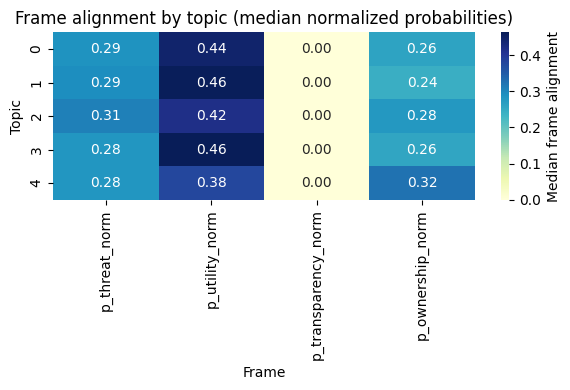

In [59]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(topic_frame, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Median frame alignment'})
plt.title("Frame alignment by topic (median normalized probabilities)")
plt.ylabel("Topic")
plt.xlabel("Frame")
plt.tight_layout(); plt.show()

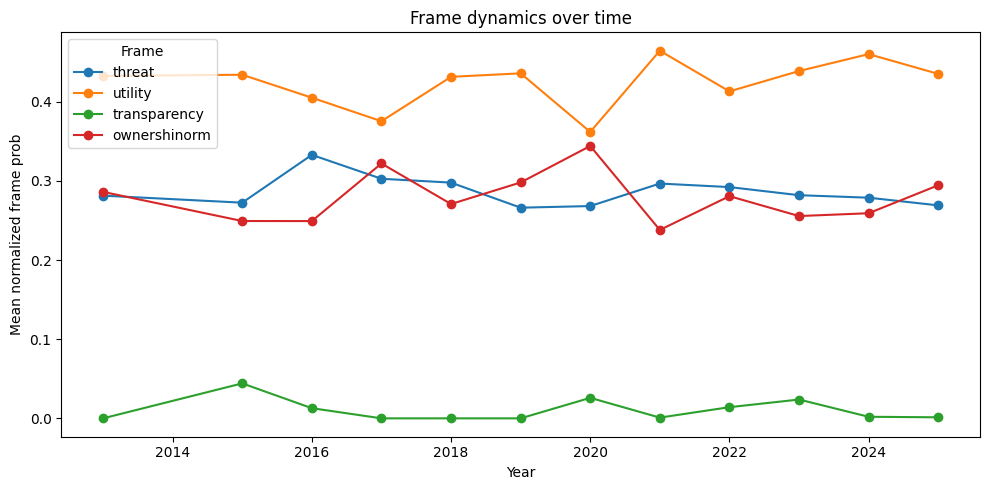

In [60]:
year_frame = (df.groupby("Year")[[p_threat, p_utility, p_transparency, p_ownership]]
                .mean().reset_index())

plt.figure(figsize=(10,5))
for col in [p_threat, p_utility, p_transparency, p_ownership]:
    plt.plot(year_frame["Year"], year_frame[col], marker="o", label=col.replace("p_","").replace("_norm",""))
plt.legend(title="Frame")
plt.xlabel("Year"); plt.ylabel("Mean normalized frame prob")
plt.title("Frame dynamics over time")
plt.tight_layout(); plt.show()

### Are frames different across D1 / D2 axes? 


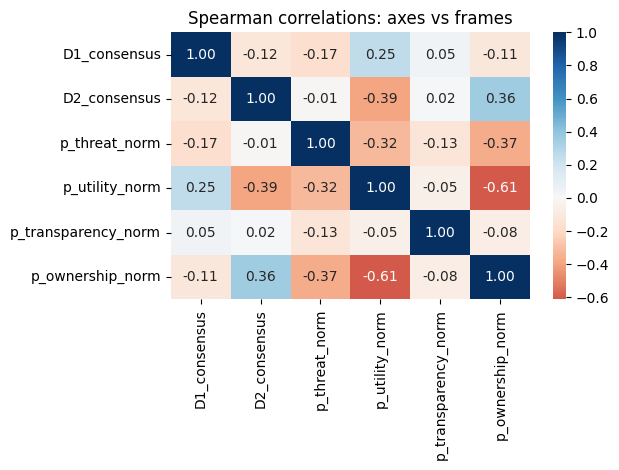

In [61]:
corr_axes_frames = df[[ "D1_consensus","D2_consensus",
                        p_threat, p_utility, p_transparency, p_ownership]].corr(method="spearman")
sns.heatmap(corr_axes_frames, annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title("Spearman correlations: axes vs frames")
plt.tight_layout(); plt.show()


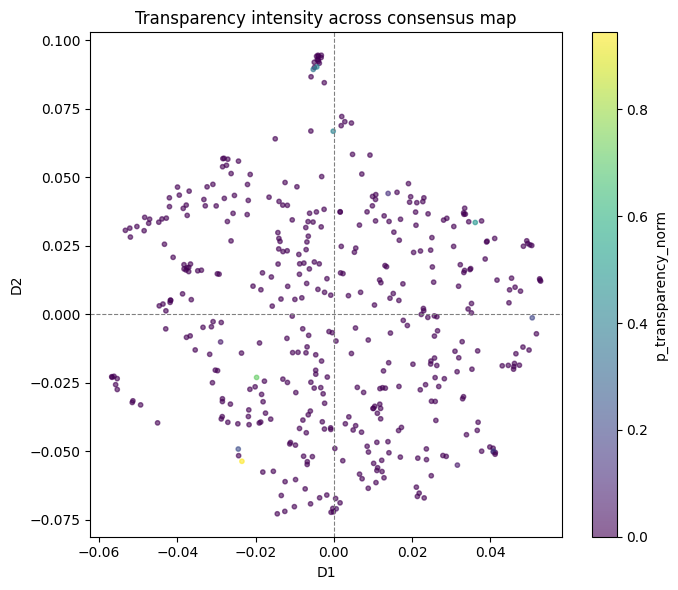

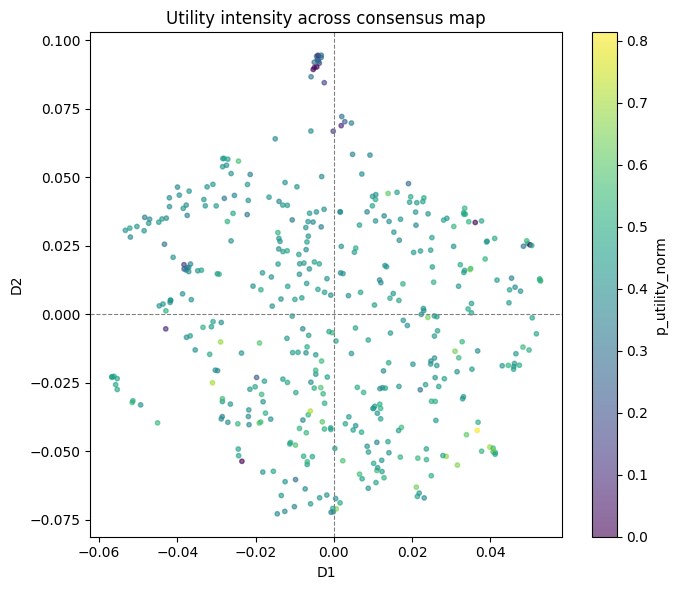

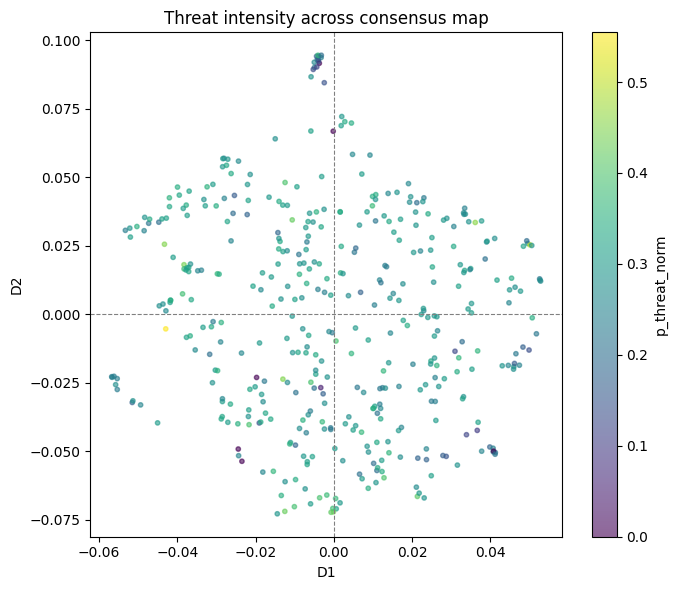

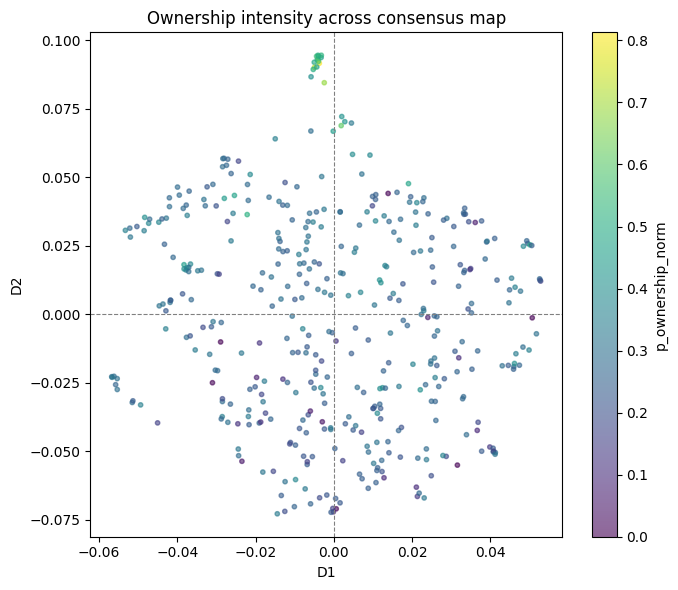

In [63]:
def umap_color(col, title):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(df["D1_consensus"], df["D2_consensus"], c=df[col], s=10, alpha=0.6, cmap="viridis")
    plt.colorbar(sc, label=col)
    plt.axhline(0, color="gray", lw=0.8, ls="--"); plt.axvline(0, color="gray", lw=0.8, ls="--")
    plt.title(title); plt.xlabel("D1"); plt.ylabel("D2")
    plt.tight_layout(); plt.show()

umap_color(p_transparency, "Transparency intensity across consensus map")
umap_color(p_utility, "Utility intensity across consensus map")
umap_color(p_threat, "Threat intensity across consensus map")
umap_color(p_ownership, "Ownership intensity across consensus map")


### Mixed-effects 

In [64]:
import statsmodels.formula.api as smf

# helper: categorical media type
df["media_type_cat"] = df["media type"].astype("category")

# D1 model
m_d1 = smf.mixedlm(
    "D1_consensus ~ " + " + ".join([p_threat, p_utility, p_transparency, p_ownership]) + " + C(media_type_cat) + Year",
    groups=df["Line Number"], data=df
).fit(reml=True)
print(m_d1.summary())

# D2 model
m_d2 = smf.mixedlm(
    "D2_consensus ~ " + " + ".join([p_threat, p_utility, p_transparency, p_ownership]) + " + C(media_type_cat) + Year",
    groups=df["Line Number"], data=df
).fit(reml=True)
print(m_d2.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/pytho

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        D1_consensus
No. Observations:         430            Method:                    REML        
No. Groups:               131            Scale:                     0.0003      
Min. group size:          1              Log-Likelihood:            1044.8618   
Max. group size:          8              Converged:                 No          
Mean group size:          3.3                                                   
--------------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
--------------------------------------------------------------------------------
Intercept                   0.938 131748.833  0.000 1.000 -258222.029 258223.905
C(media_type_cat)[T.audio]  0.010      0.004  2.343 0.019       0.002      0.018
C(media_type_cat)[T.paper] -0.010      0.007 -1.42

/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_py39/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        D2_consensus
No. Observations:          430            Method:                    REML        
No. Groups:                131            Scale:                     0.0003      
Min. group size:           1              Log-Likelihood:            1005.0304   
Max. group size:           8              Converged:                 Yes         
Mean group size:           3.3                                                   
---------------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------------------------
Intercept                   15.033 209186.016  0.000 1.000 -409982.024 410012.091
C(media_type_cat)[T.audio]  -0.038      0.004 -8.834 0.000      -0.046     -0.029
C(media_type_cat)[T.paper]   0.015    

In [65]:
from scipy.stats import kruskal

for col in [p_threat, p_utility, p_transparency, p_ownership, "fk_grade", "lexical_diversity"]:
    groups = [g[col].dropna().values for _, g in df.groupby("topic_consensus")]
    stat, p = kruskal(*groups)
    print(f"{col}: Kruskal-Wallis H={stat:.2f}, p={p:.3e}")


p_threat_norm: Kruskal-Wallis H=14.76, p=5.225e-03
p_utility_norm: Kruskal-Wallis H=80.66, p=1.262e-16
p_transparency_norm: Kruskal-Wallis H=10.55, p=3.217e-02
p_ownership_norm: Kruskal-Wallis H=53.05, p=8.306e-11
fk_grade: Kruskal-Wallis H=46.92, p=1.581e-09
lexical_diversity: Kruskal-Wallis H=97.41, p=3.503e-20


### How well do the NLI and Prototype similarity scoring methods agree? 

In [66]:
agree = {}
for f in ["threat","utility","transparency","ownership"]:
    r = df[f"p_{f}_nli_med"].corr(df[f"p_{f}_proto_med"])
    mae = np.abs(df[f"p_{f}_nli_med"] - df[f"p_{f}_proto_med"]).mean()
    agree[f] = {"pearson_r": r, "MAE": mae}
pd.DataFrame(agree).T


,pearson_r,MAE
threat,0.136539,0.128018
utility,0.300227,0.125737
transparency,0.103474,0.292002
ownership,0.388940,0.085518


In [67]:
milestones = {2018:"Christie's AI sale", 2022:"Stable Diffusion", 2023:"Andersen v Stability AI"}
from scipy.stats import ranksums

for yr, label in milestones.items():
    pre = df.loc[df["Year"] < yr, p_transparency]
    post = df.loc[df["Year"] >= yr, p_transparency]
    stat, p = ranksums(pre, post)
    print(f"Transparency pre vs post {yr} ({label}): z={stat:.2f}, p={p:.3e}")


Transparency pre vs post 2018 (Christie's AI sale): z=0.38, p=7.037e-01
Transparency pre vs post 2022 (Stable Diffusion): z=0.16, p=8.750e-01
Transparency pre vs post 2023 (Andersen v Stability AI): z=0.16, p=8.768e-01


In [68]:
for yr, label in milestones.items():
    pre = df.loc[df["Year"] < yr, p_threat]
    post = df.loc[df["Year"] >= yr, p_threat]
    stat, p = ranksums(pre, post)
    print(f"Threat pre vs post {yr} ({label}): z={stat:.2f}, p={p:.3e}")

Threat pre vs post 2018 (Christie's AI sale): z=1.93, p=5.385e-02
Threat pre vs post 2022 (Stable Diffusion): z=0.55, p=5.830e-01
Threat pre vs post 2023 (Andersen v Stability AI): z=1.17, p=2.400e-01


In [69]:
for yr, label in milestones.items():
    pre = df.loc[df["Year"] < yr, p_ownership]
    post = df.loc[df["Year"] >= yr, p_ownership]
    stat, p = ranksums(pre, post)
    print(f"Ownership pre vs post {yr} ({label}): z={stat:.2f}, p={p:.3e}")

Ownership pre vs post 2018 (Christie's AI sale): z=0.28, p=7.805e-01
Ownership pre vs post 2022 (Stable Diffusion): z=0.98, p=3.254e-01
Ownership pre vs post 2023 (Andersen v Stability AI): z=1.39, p=1.642e-01


In [70]:
for yr, label in milestones.items():
    pre = df.loc[df["Year"] < yr, p_utility]
    post = df.loc[df["Year"] >= yr, p_utility]
    stat, p = ranksums(pre, post)
    print(f"Utility pre vs post {yr} ({label}): z={stat:.2f}, p={p:.3e}")

Utility pre vs post 2018 (Christie's AI sale): z=-1.85, p=6.417e-02
Utility pre vs post 2022 (Stable Diffusion): z=-1.83, p=6.668e-02
Utility pre vs post 2023 (Andersen v Stability AI): z=-2.79, p=5.262e-03


<br>
<br>
<hr>
<br>
<br>

